In [271]:
#importing libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from matplotlib.patches import Rectangle
import random
import warnings
warnings.filterwarnings("ignore")


# Part 1


## Defining CatQuest Environment

In [251]:
class CatQuestEnvironment(gym.Env):
    metadata = { 'render.modes': []}
    def __init__(self, env_type, n, max_steps):
        self.env_type = env_type
        self.space = spaces.Discrete(n)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_steps
        self.height = 6
        self.width = 6        
        self.timestep = 0
        self.cat_pos = [0, 0]
        self.milk_pos = [[1, 0], [3, 0], [1, 2],  [5, 2], [3, 4],
                                       [1, 4],[0, 5], [2, 5], [4, 5], [5, 1]]
        self.fish_pos = [2, 4]
        self.traps_pos = [[2, 0], [2, 2], [0, 4], [3, 5], [0, 1], [2, 1]]
        self.water_pos = [[0, 2], [3, 2], [4, 3], [1, 5]]

        self.fish_quantity = 1
        self.reward_dict = {}
        self.reward =0
        self.dog_pos = [3, 3]
        for row in self.milk_pos:
            self.reward_dict[tuple(row)] = 3
        self.reward_dict[tuple([2,4])] = 10
        for row in self.water_pos:
            self.reward_dict[tuple(row)] = -1            
        for row in self.traps_pos:
            self.reward_dict[tuple(row)] = -2
        self.reward_dict[tuple([3, 3])] = -5
        self.max_timesteps = max_steps
        self.visited_pos = []
#         print('Starting state of the cat is', self.cat_pos)
#         print('Current action: Cat is at stationary position not taking any action')
#         print("*"*120)
        
    def reset(self):
        self.reward = 0
        self.timestep = 0
        self.visited_pos = []
        self.cat_pos = [0, 0]
        self.fish_pos = [2, 4]
        
    def step(self, action):   
        self.reward = 0
        action_dict = {0:"up", 2:"left", 1: "down", 3:"right"}  
        if action == 3: #right
            self.cat_pos[0] += 1
        if action == 2: #left
            self.cat_pos[0] -= 1
        if action == 0: #up
            self.cat_pos[1] += 1
        if action == 1: #down
            self.cat_pos[1] -= 1
     
        self.cat_pos = np.clip(self.cat_pos, 0, 5) 


        goal_reached  = False
        if tuple(self.cat_pos) in self.reward_dict:
            self.reward = self.reward_dict[tuple(self.cat_pos)]
            
            
        if np.array_equal(self.cat_pos, self.fish_pos) or self.timestep > self.max_timesteps:
            goal_reached = True
            stopped = True
        self.timestep +=1
        stopped = True if self.timestep >= self.max_timesteps else False   
        if np.all((self.cat_pos >=0) & (self.cat_pos <= 5)):
            truncated = True
        else:
            truncated = False
        
       # print(f"The cat positions are {self.cat_pos}")
        if any(np.array_equal(self.cat_pos, pos) for pos in self.visited_pos):
            self.reward = 0
        else:
            self.visited_pos.append(self.cat_pos.copy())

#
        if self.cat_pos[0] == 0:                                                                                              # Logic to get current state
            state = self.cat_pos[1]
        elif self.cat_pos[0] == 1:
            state = 6 + self.cat_pos[1]
        elif self.cat_pos[0] == 2:
            state = 12 + self.cat_pos[1]
        elif self.cat_pos[0] == 3:
            state = 18 + self.cat_pos[1]
        elif self.cat_pos[0] == 4:
            state = 24 + self.cat_pos[1]
        else:
            state = 30 + self.cat_pos[1]
        return state, goal_reached, self.reward, stopped, truncated
       
        
    def render(self, mode = 'human', plot = False):
        fig, ax = plt.subplots(figsize = (13, 13))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
        
        def plot_image(pos):  
            plot_cat, plot_milk, plot_fish, plot_traps, plot_water, plot_dog = False, False, False, False, False, False
            if np.array_equal(self.cat_pos, pos):
                plot_cat = True
            if any(np.array_equal(self.milk_pos[i], pos) for i in range(len(self.milk_pos))):
                plot_milk = True
            if self.fish_quantity > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
                if np.array_equal(pos, self.fish_pos):
                    plot_fish = True
            if any(np.array_equal(self.traps_pos[i], pos) for i in range(len(self.traps_pos))):
                plot_traps = True
            if any(np.array_equal(self.water_pos[i], pos) for i in range(len(self.water_pos))):
                plot_water = True
            if np.array_equal(pos, self.dog_pos):
                plot_dog = True
            #plot for cat
            if plot_cat and all(not item for item in [plot_milk, plot_fish, plot_traps, plot_water, plot_dog]):
                cat = AnnotationBbox(OffsetImage(plt.imread('Images/cat.png'), zoom=0.20),np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cat)
            #plot for milk
            elif plot_milk and all(not item for item in [plot_cat, plot_fish, plot_traps, plot_water, plot_dog]):
                milk = AnnotationBbox(OffsetImage(plt.imread('Images/milk.jpeg'), zoom=0.26),np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(milk)
           # Plot for fish.
            elif plot_fish and all(not item for item in [plot_cat, plot_milk, plot_traps, plot_water, plot_dog]):
                fish = AnnotationBbox(OffsetImage(plt.imread('Images/fish.png'), zoom=0.12), np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(fish)
           # Plot for traps.
            elif plot_traps and all(not item for item in [plot_cat, plot_milk, plot_fish, plot_water, plot_dog]):
                traps = AnnotationBbox(OffsetImage(plt.imread('Images/traps.webp'), zoom=0.06),
                                    np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(traps)
           # Plot for water.
            elif plot_water and all(not item for item in [plot_cat, plot_milk, plot_fish, plot_traps, plot_dog]):
                water = AnnotationBbox(OffsetImage(plt.imread('Images/water.png'), zoom=0.15),np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(water)
           # Plot for dog.
            elif plot_dog and all(not item for item in [plot_cat, plot_milk, plot_fish, plot_traps, plot_water]):                
                dog = AnnotationBbox(OffsetImage(plt.imread('Images/dog.png'), zoom=0.28),np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(dog)
           # Plot for cat and milk.
            elif all(item for item in [plot_cat, plot_milk]) and all(not item for item in [plot_fish, plot_traps, plot_water, plot_dog]):
                cat_milk = AnnotationBbox(OffsetImage(plt.imread('Images/cat_milk.png'), zoom=0.20),np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cat_milk)
           # Plot for cat and traps.
            elif all(item for item in [plot_cat, plot_traps]) and all(not item for item in [plot_milk, plot_fish, plot_water, plot_dog]):
                cat_traps = AnnotationBbox(OffsetImage(plt.imread('Images/cat_trap.jpeg'), zoom=0.19), np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cat_traps)

           # Plot for cat and water.
            elif all(item for item in [plot_cat, plot_water]) and all(not item for item in [plot_milk, plot_fish, plot_traps, plot_dog]):
                cat_water = AnnotationBbox(OffsetImage(plt.imread('Images/cat_water.png'), zoom=0.20), np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cat_water)
           # Plot for cat and dog.
            elif all(item for item in [plot_cat, plot_dog]) and all(not item for item in[plot_fish, plot_traps, plot_water, plot_milk]):
                cat_dog = AnnotationBbox(OffsetImage(plt.imread('Images/cat_dog.png'),zoom=0.18), np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cat_dog)
                self.reset()
                print("GAME OVER")
            elif all(item for item in [plot_cat, plot_fish]) and all(not item for item in[plot_dog, plot_traps, plot_water, plot_milk]):
                cat_dog = AnnotationBbox(OffsetImage(plt.imread('Images/cat_fish.png'),zoom=0.12), np.add(pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cat_dog)         
        self.state_mapping = {}
        for j in range(self.height * self.width):
             self.state_mapping[j] = np.asarray([j % self.width, int(np.floor(j / self.width))])


        for position in self.state_mapping:
            plot_image(self.state_mapping[position])
        plt.title('Cat Quest',  fontsize= 20,  fontweight='bold')

        plt.xticks([0, 1, 2, 3, 4, 5])
        plt.yticks([0, 1, 2, 3, 4, 5])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 40
            height = 40
            dim = (width, height)           
            plt.show()


## Visualization of the Complete CatQuestEnvironment



Starting state of the cat is [0, 0]
Current action: Cat is at stationary position not taking any action
************************************************************************************************************************


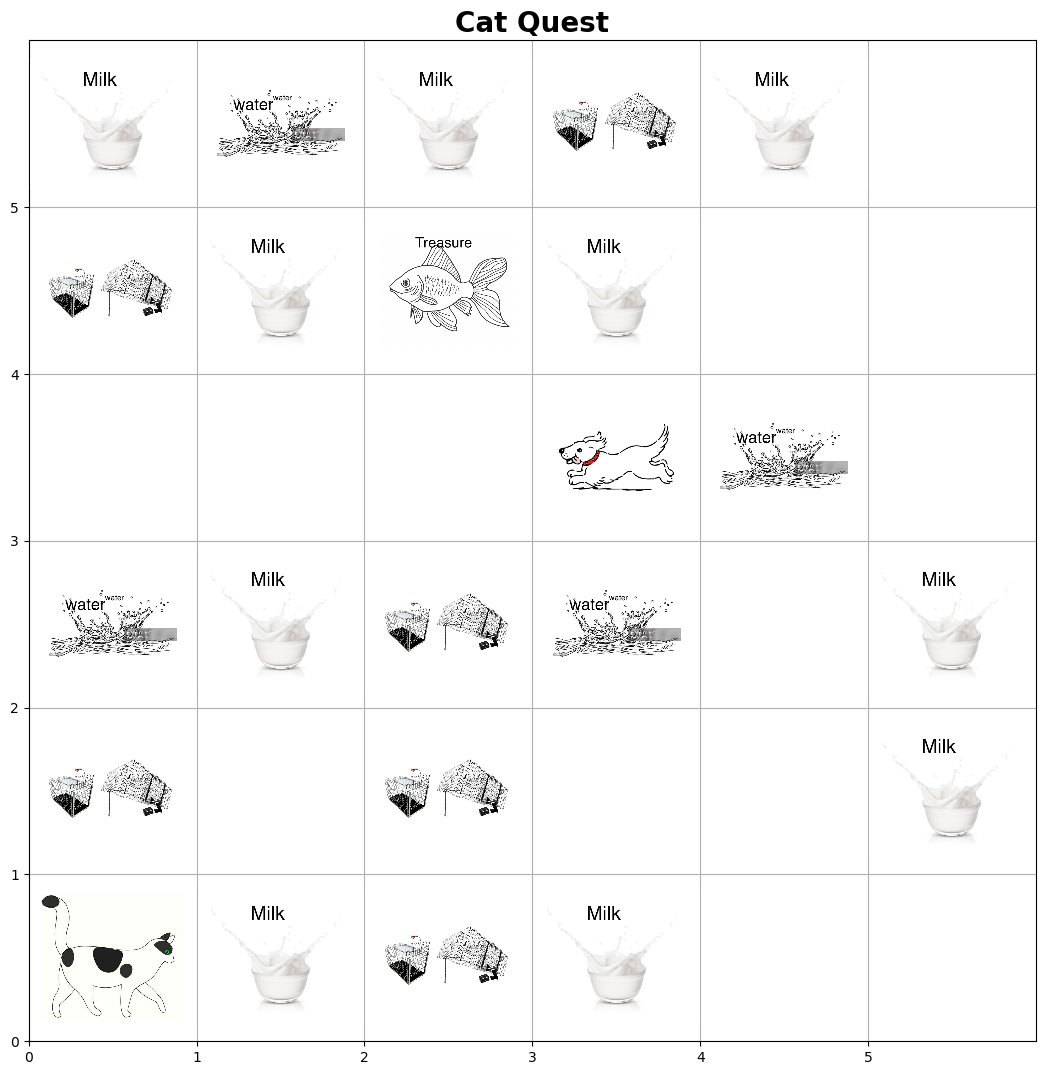

In [229]:
action_dict = {0:"up", 1:"down", 2: "left", 3:"right"}   
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
cat_quest.render(plot = True)

# Cat moving in Cat Quest Environment for 11 Steps randomly

Starting state of the cat is [0, 0]
Current action: Cat is at stationary position not taking any action
************************************************************************************************************************
Cat Current Position 0, Action: down, Reward: 0, Goal Reached: False, trauncated: True


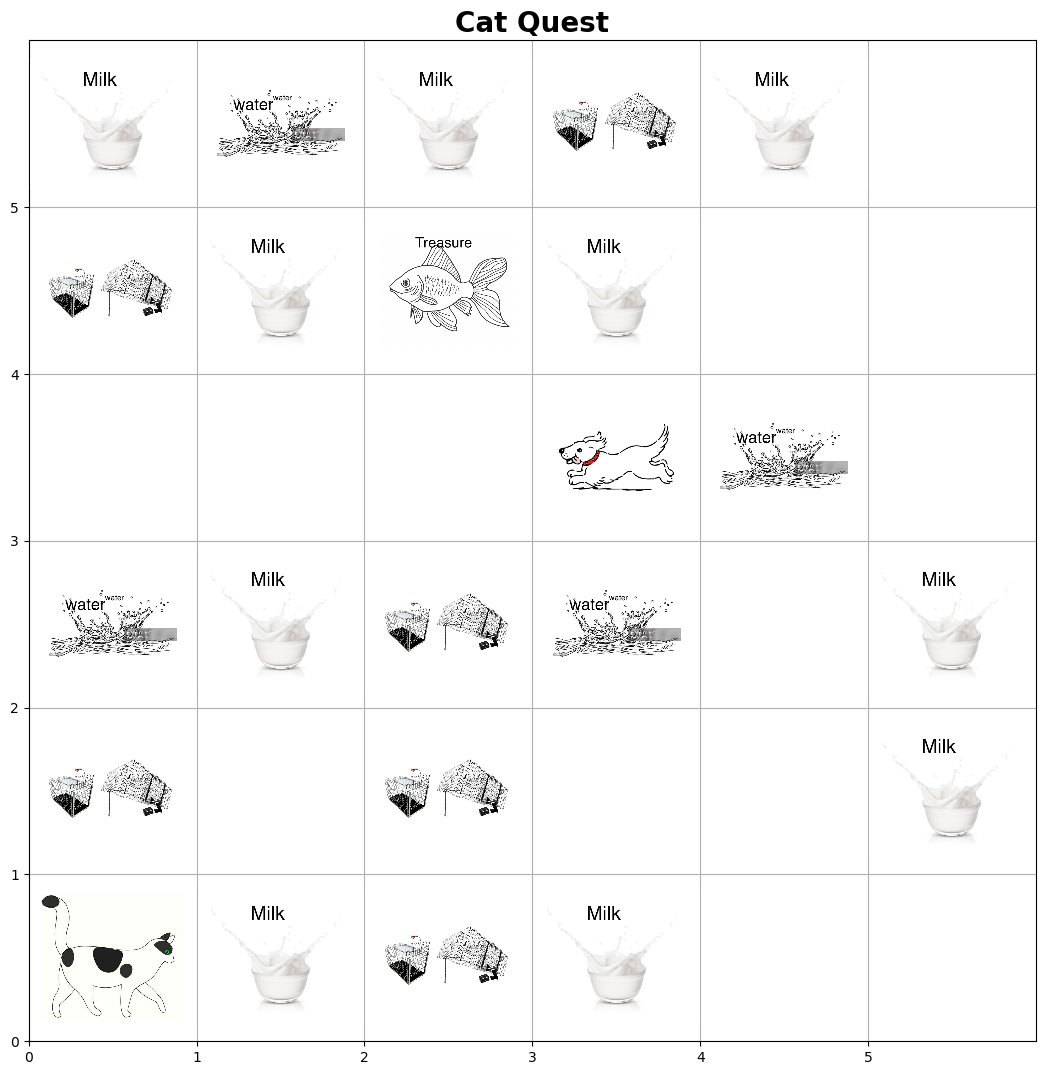

************************************************************************************************************************
Cat Current Position 6, Action: right, Reward: 3, Goal Reached: False, trauncated: True


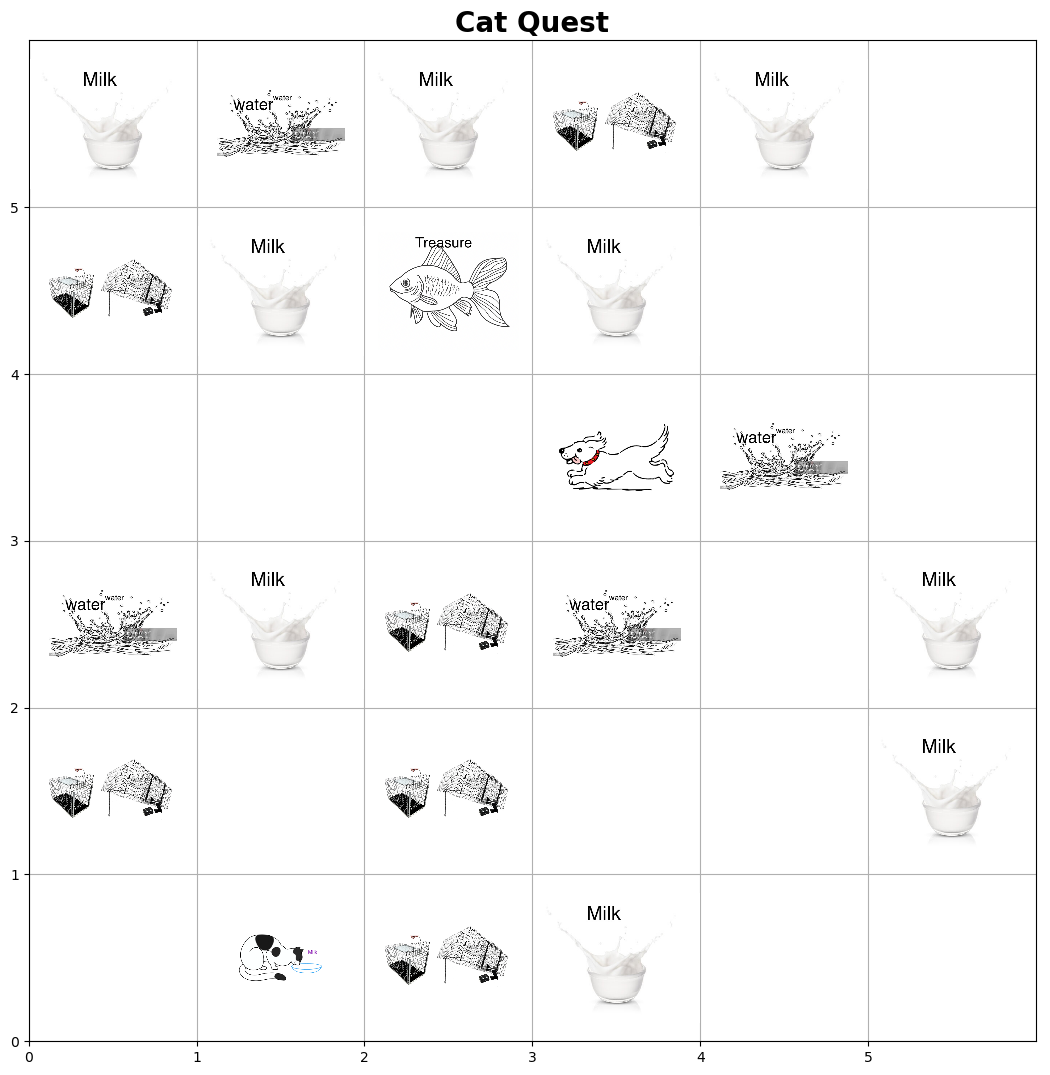

************************************************************************************************************************
Cat Current Position 6, Action: down, Reward: 0, Goal Reached: False, trauncated: True


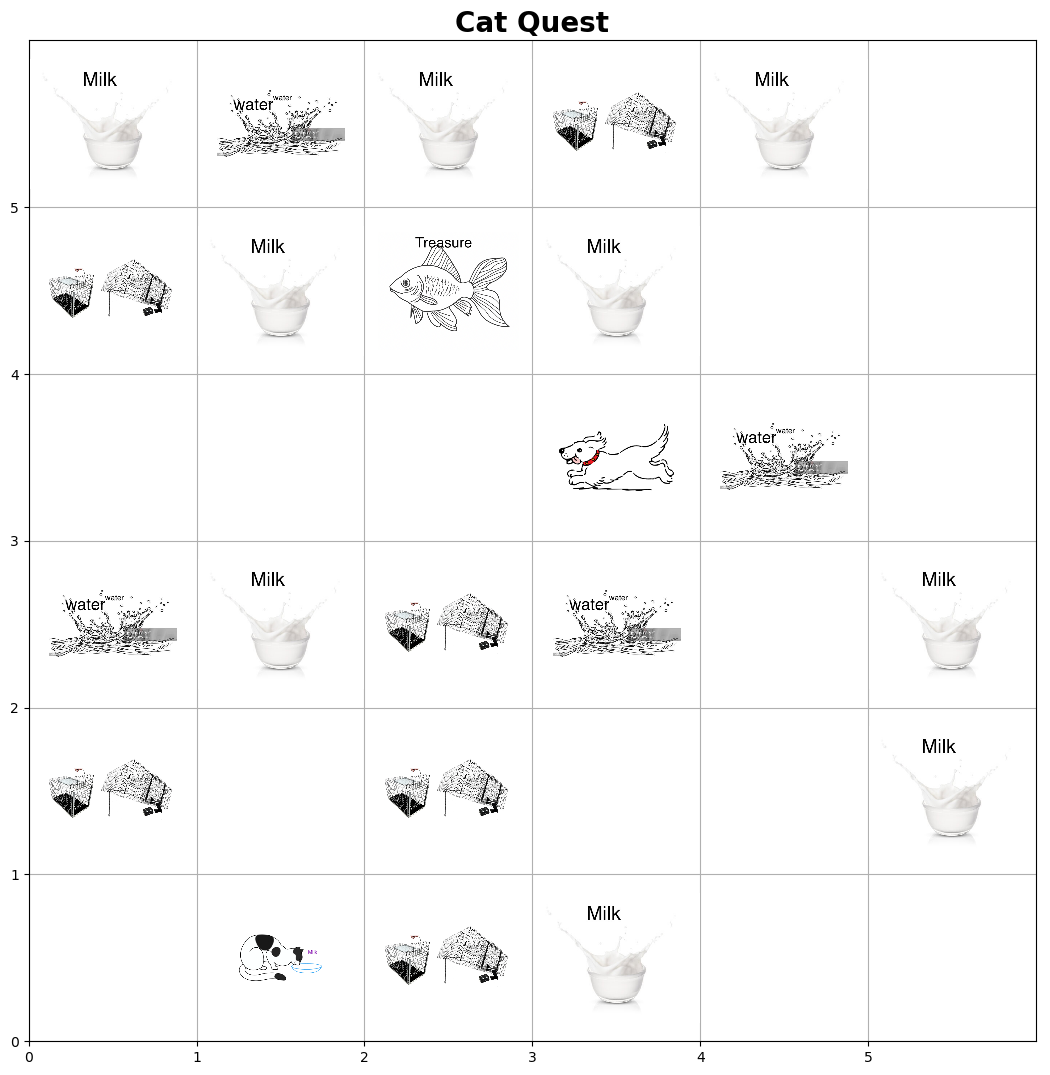

************************************************************************************************************************
Cat Current Position 7, Action: up, Reward: 0, Goal Reached: False, trauncated: True


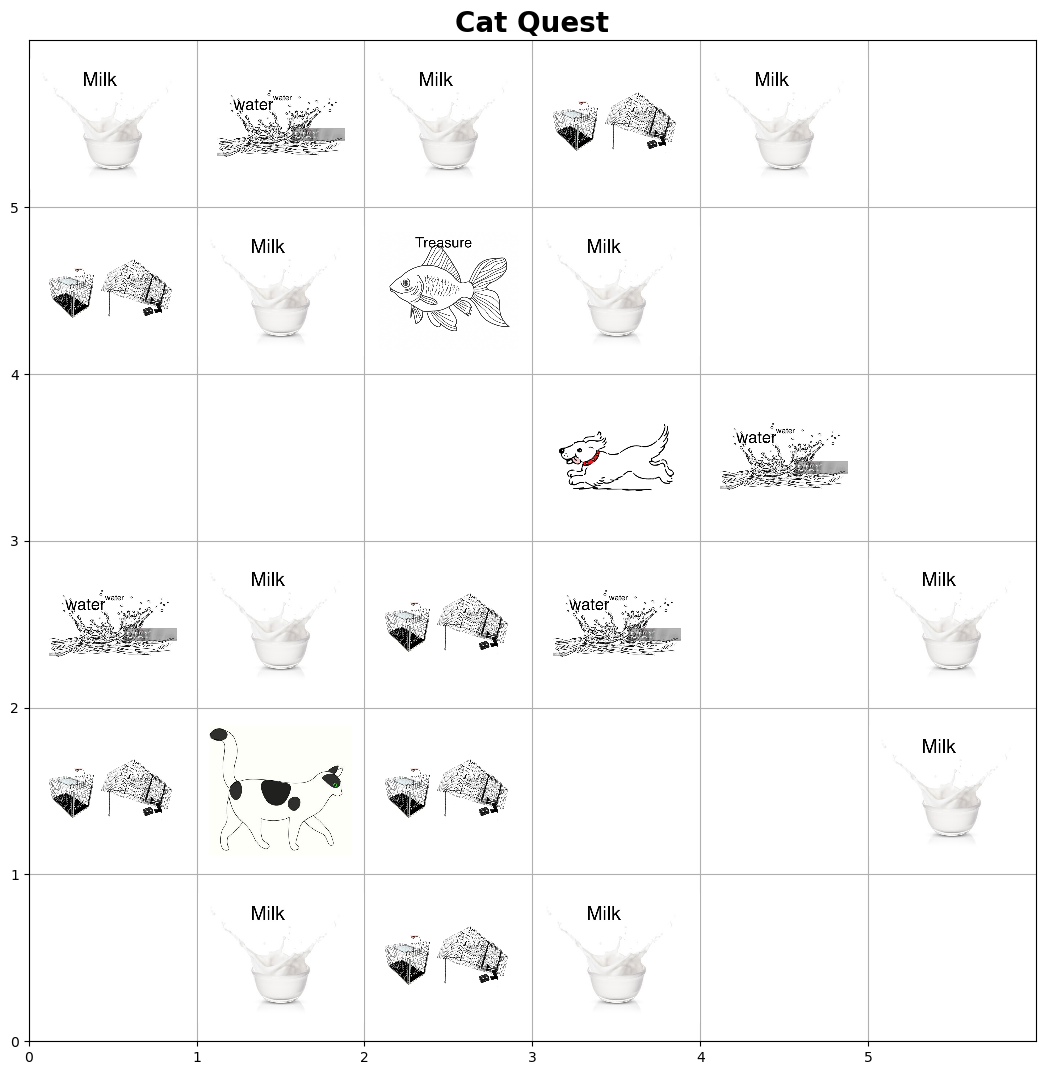

************************************************************************************************************************
Cat Current Position 1, Action: left, Reward: -2, Goal Reached: False, trauncated: True


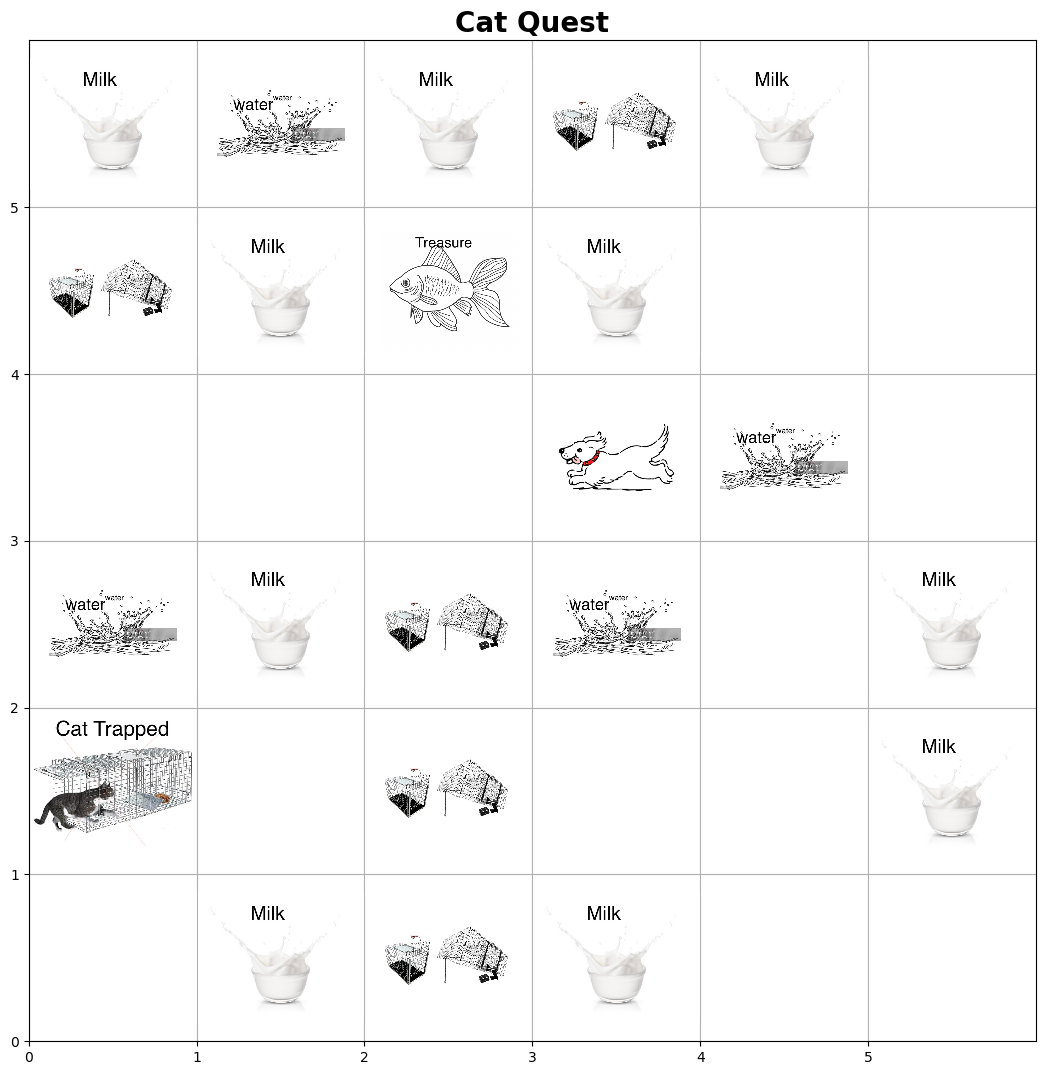

************************************************************************************************************************
Cat Current Position 2, Action: up, Reward: -1, Goal Reached: False, trauncated: True


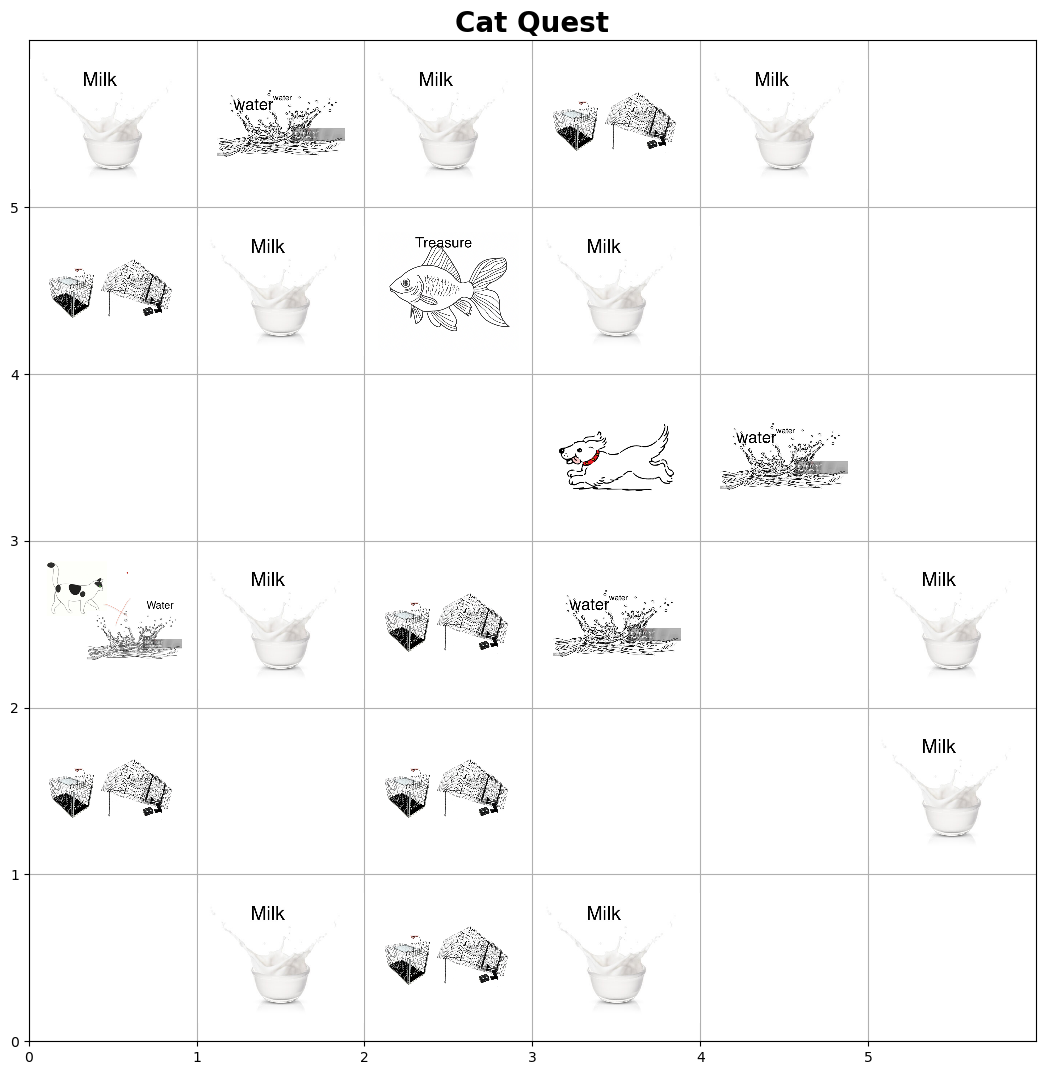

************************************************************************************************************************
Cat Current Position 8, Action: right, Reward: 3, Goal Reached: False, trauncated: True


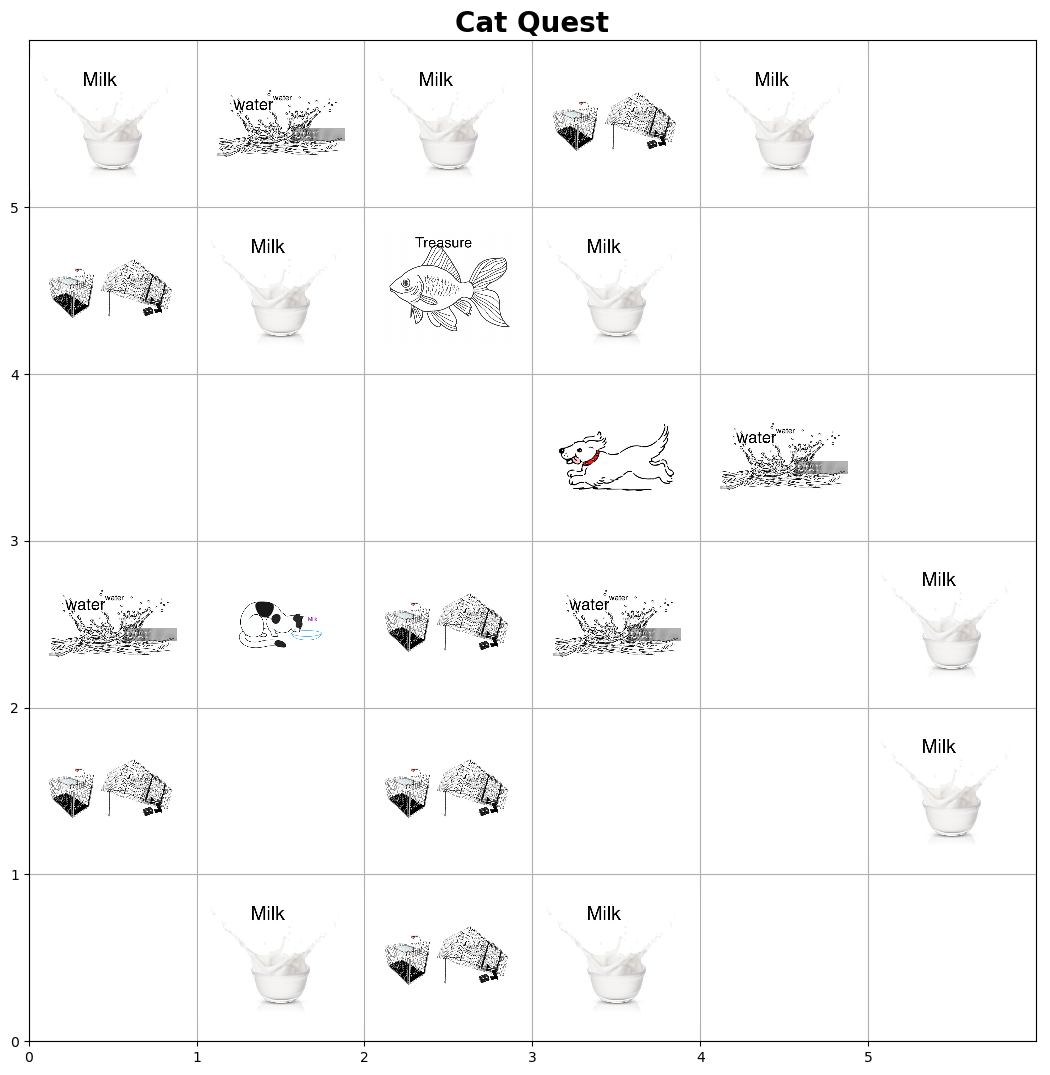

************************************************************************************************************************
Cat Current Position 2, Action: left, Reward: 0, Goal Reached: False, trauncated: True


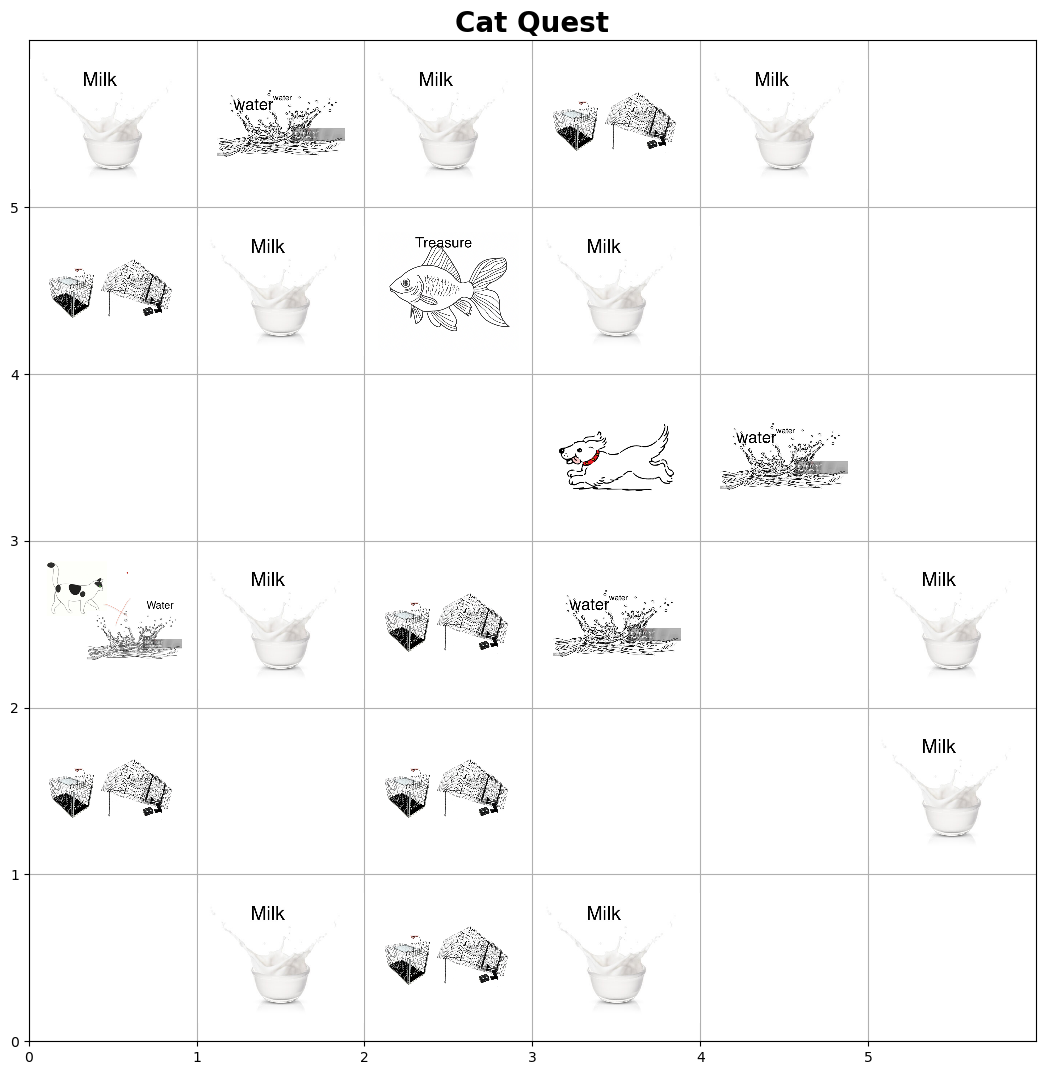

************************************************************************************************************************
Cat Current Position 3, Action: up, Reward: 0, Goal Reached: False, trauncated: True


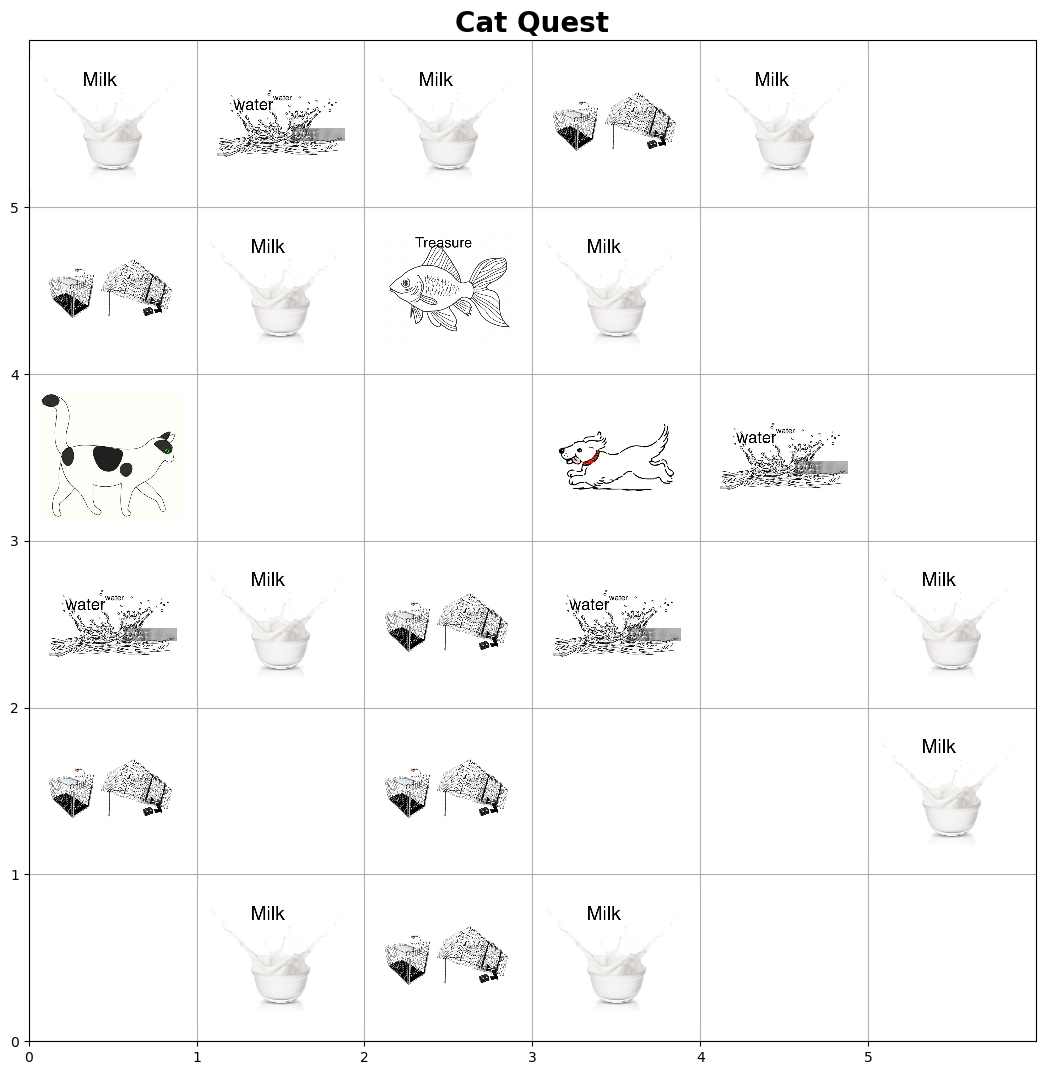

************************************************************************************************************************
Cat Current Position 2, Action: down, Reward: 0, Goal Reached: False, trauncated: True


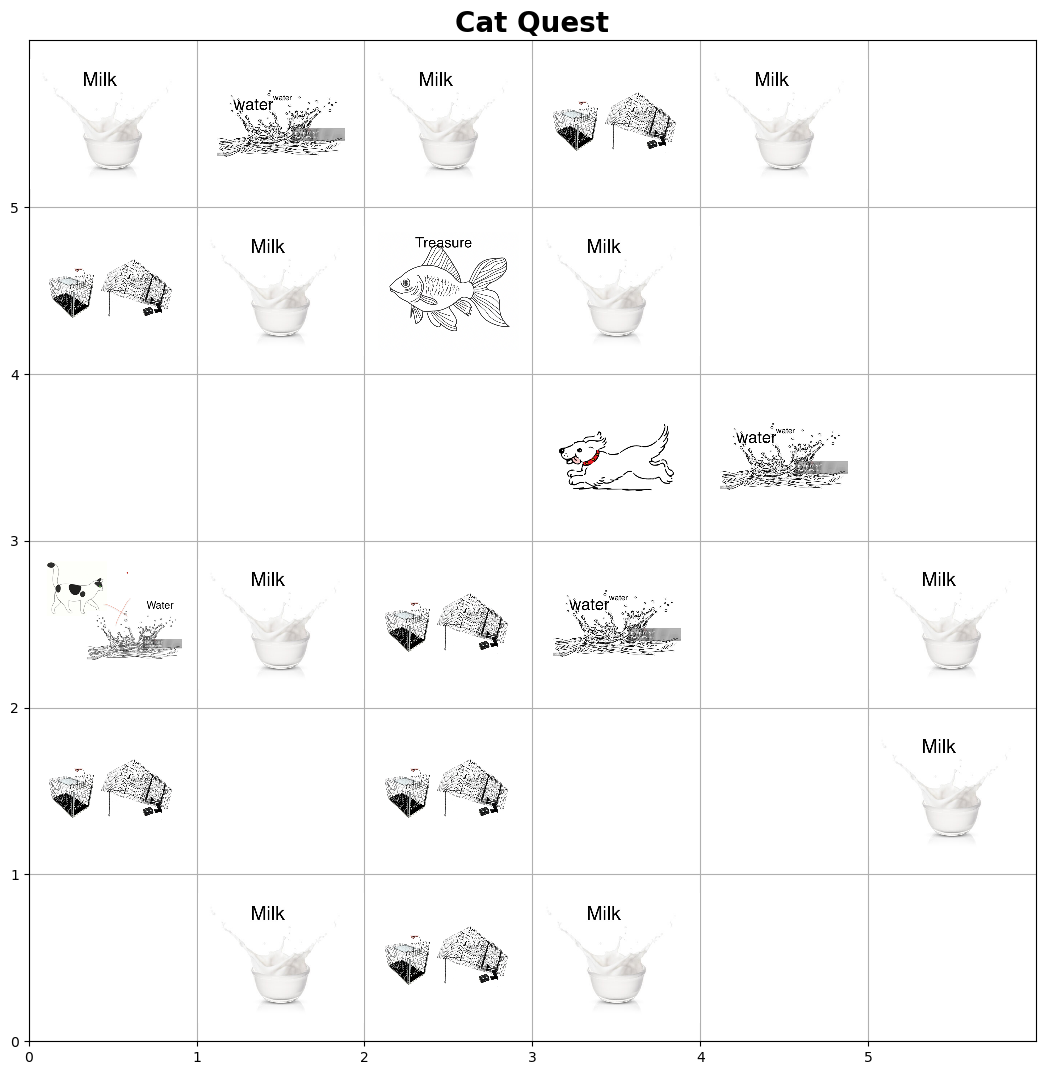

************************************************************************************************************************
Cat Current Position 2, Action: left, Reward: 0, Goal Reached: False, trauncated: True


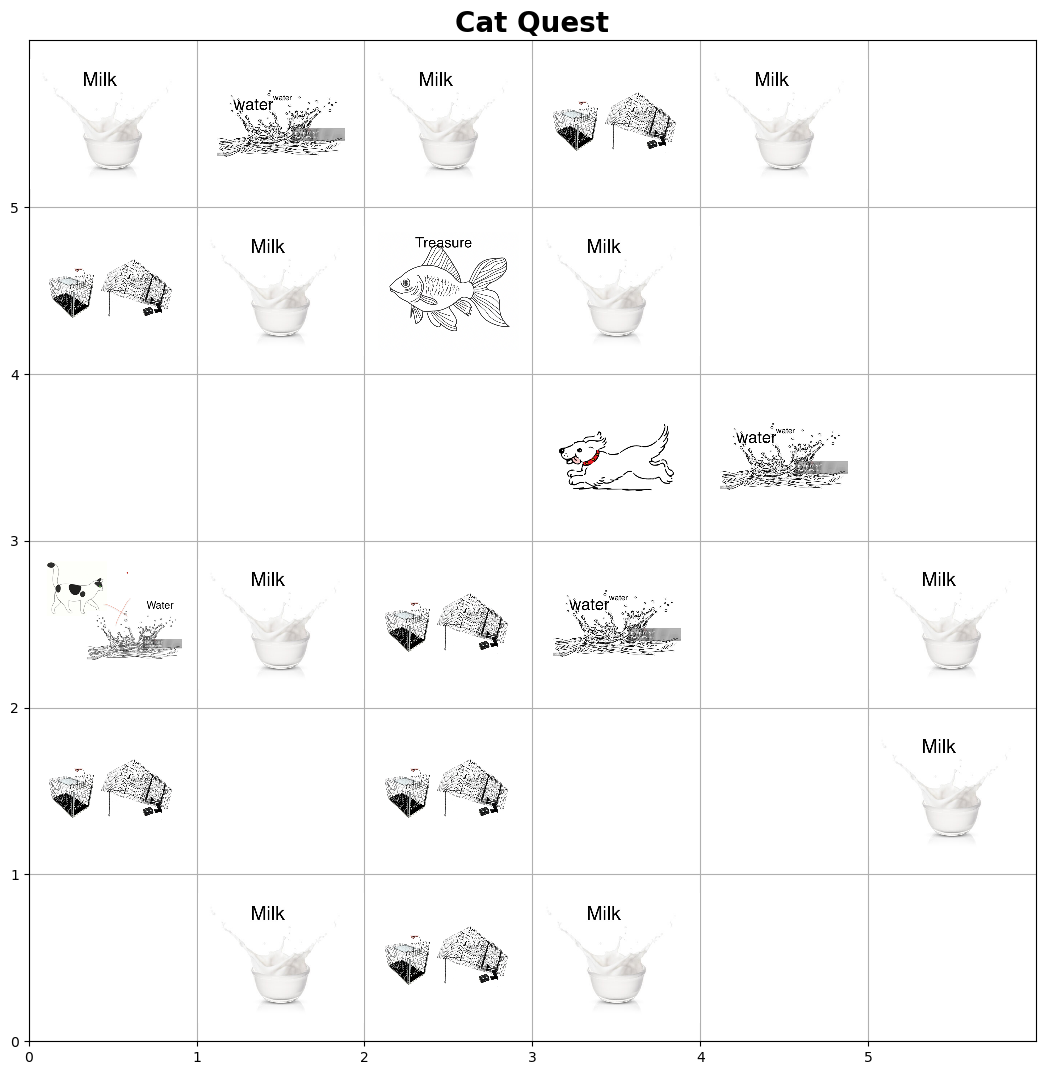

************************************************************************************************************************


In [231]:
finished = False
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36, max_steps = 11)
while not finished:
    action = cat_quest.action_space.sample()
    state, goal_reached, reward, finished, truncated = cat_quest.step(action)
    print(f"Cat Current Position {state}, Action: {action_dict[action]}, Reward: {reward}, Goal Reached: {goal_reached}, trauncated: {truncated}")
    if truncated:
        cat_quest.render(plot = True)
    print('*'*120)

# Part 2 SARSA Implementation:

In [153]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
total_state = cat_quest.space.n
total_action = cat_quest.action_space.n
epsilon=0.01
total_episodes = 1000
learning_rate = 0.1
gamma = 0.9
Isgreedy = False
print(f"Total Number of states {total_state} and total number of actions are {total_action}")
print(f"Learning rate (alpha): {learning_rate}\nDiscount_factor: {gamma}\nTotal Episodes: {total_episodes}")
print("*"*120)


Total Number of states 36 and total number of actions are 4
Learning rate (alpha): 0.1
Discount_factor: 0.9
Total Episodes: 1000
************************************************************************************************************************


# SARSA Using  ∑-greedy policy

In [154]:
def SARSA_algorithm(cat_quest,df, max_steps, Q_table, Isgreedy, gamma, learning_rate, total_episodes):
    epsilon_list = []
    cummulative_score = []
    final_epsilon =0
    initial_epsilon =1

    
    for episode in range(total_episodes):
        cat_quest.reset()
        state = 0
        goal_reached = False   
        steps = 0
        score = 0  
        action_list = []
        cat = []
        
        epsilon = final_epsilon + (initial_epsilon - final_epsilon) * np.exp(-df * episode)  
        
        if Isgreedy or np.any(np.random.uniform(0, 1) > epsilon):
            action =  np.argmax(Q_table[state])
        else:
            action = cat_quest.action_space.sample()
        while not goal_reached and steps <= max_steps:
            steps += 1
            state_, goal_reached, reward, finished, truncated = cat_quest.step(action)
            #print(reward, end = ' ')
            score += reward
            if Isgreedy or np.any(np.random.uniform(0, 1) > epsilon):
                action_ =  np.argmax(Q_table[state_])
            else:
                action_ = cat_quest.action_space.sample()
            Q_table[state,action] = Q_table[state,action]+ learning_rate * (
                reward + gamma * Q_table[state_, action_] - Q_table[state,action])            
            cat.append(cat_quest.cat_pos)            
            action = action_
            state = state_ 
            action_list.append(action)
        epsilon_list.append(epsilon)
        cummulative_score.append(score)
    return epsilon_list, cummulative_score, Q_table       
            

# Graphs

In [247]:
def graphs(total_episodes, SARSA_scores, epsilon_List):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].plot(SARSA_scores)
    axs[0].set_title('Total Reward for the graph')
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Scores')
    axs[0].grid()
    axs[1].plot(epsilon_List)
    axs[1].set_title('Epsilon Decay Graph')
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Epsilon')
    axs[1].grid()
    plt.tight_layout()
    plt.show()

In [252]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
Q_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
inital_Q = Q_table.copy()
epsilon_List, SARSA_scores, Q_table = SARSA_algorithm(cat_quest,epsilon, 100, Q_table, Isgreedy, gamma, learning_rate, 1000)


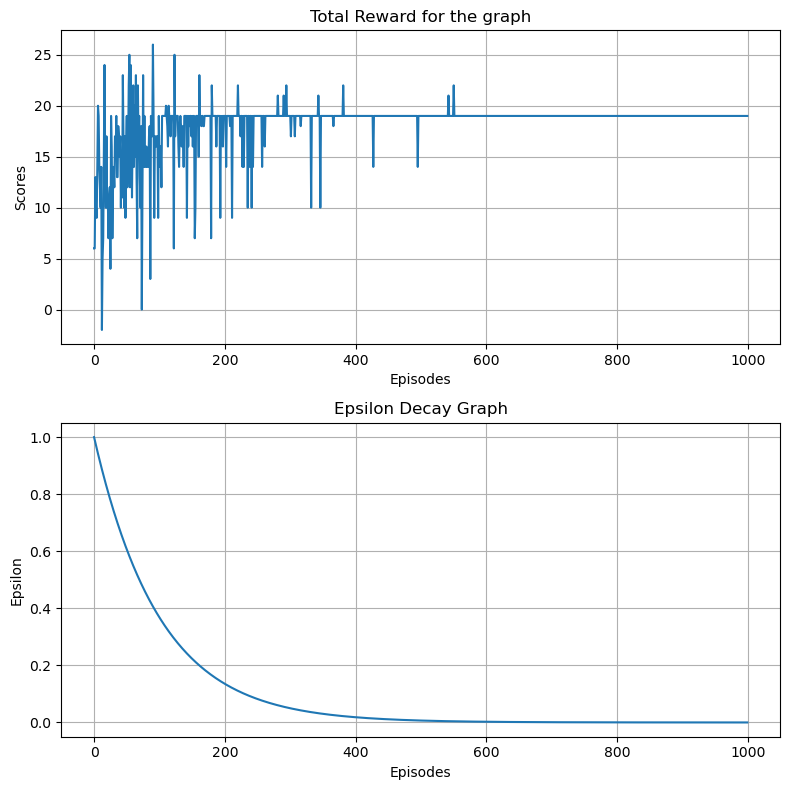

In [249]:
graphs(total_episodes, SARSA_scores, epsilon_List)

In [159]:
print(f"Intial Q table values:\n{inital_Q}\n{'*'*20}Trained Q table values{'*'*20}\n{Q_table}")

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[ 2.10152100e-01  2.99961027e+00  5.04731527e+00  1.33032000e+01]
 [ 6.12930247e-02  9.57817276e-01  8.24951436e-01  6.11775998e+00]
 [ 5.29274316e-01  7.15194514e-01  8.51252678e-01  5.94233018e+00]
 [-5.21636368e-01  2.42486746e-01  1.25819881e+00  7.41635143e+00]
 [ 2.15042750e+00 -3.25080416e-02  9.36169290e-01  7.76087825e+00]
 [ 2.46452389e-02 -3.41134400e-01 -1.8

# Agent choosing only greedy actions from the learned policy SARSA Algorithm

In [253]:
Isgreedy = True
gamma = 0.99
total_episodes = 10
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
epsilon_List, SARSA_scores_greedy, Q_table = SARSA_algorithm(cat_quest,epsilon, 200, Q_table, Isgreedy, gamma, learning_rate, total_episodes)

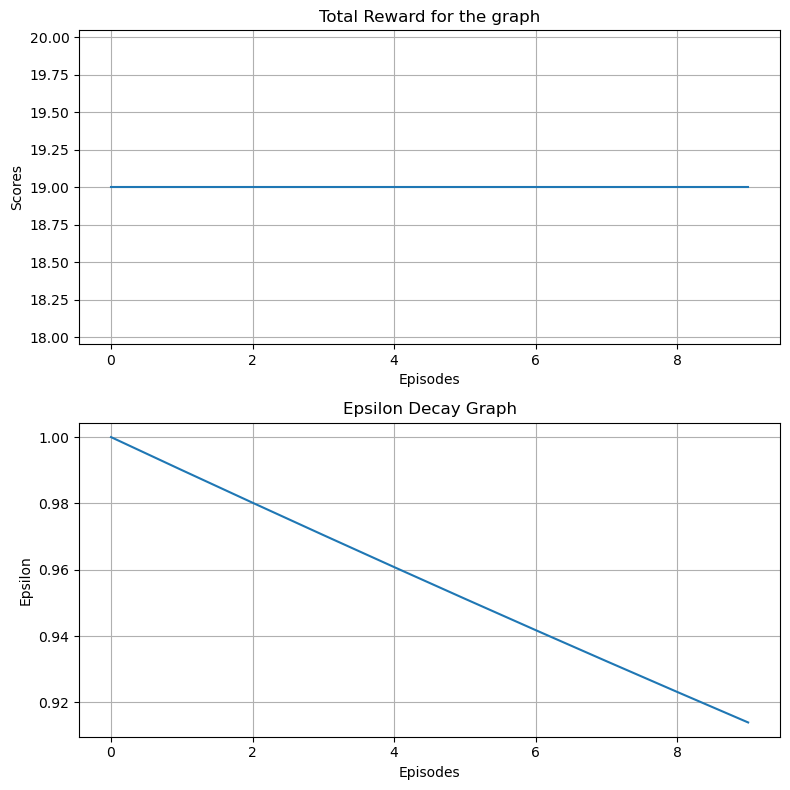

In [254]:
graphs(total_episodes, SARSA_scores_greedy, epsilon_List)

# Discount Factor -> [0.40, 0.65, 0.80] : HyperParameter Tuning

****************************** Evaluation Results : Discount Factor value is 0.4 ******************************


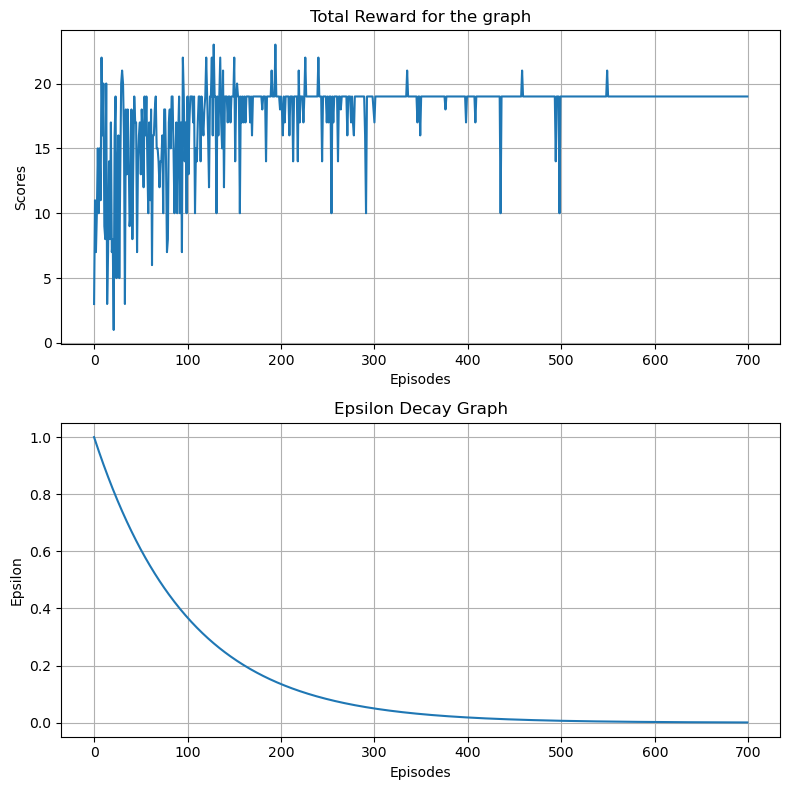

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[-1.66097344e+00  8.89403563e-01  9.34986881e-01  3.65503015e+00]
 [-5.83636542e-01  1.11758683e+00  6.68235550e-02  4.23476360e-01]
 [ 8.66343858e-02 -2.37319834e-01  1.63881002e-01  8.41024479e-01]
 [-9.33314109e-01 -9.23908071e-03 -5.16150781e-03  1.83977211e+00]
 [ 2.00510706e+00 -2.38256585e-02  1.87229615e-01  1.34847778e+00]
 [-9.30422480e-03 -1.65676321e-01 -5.0

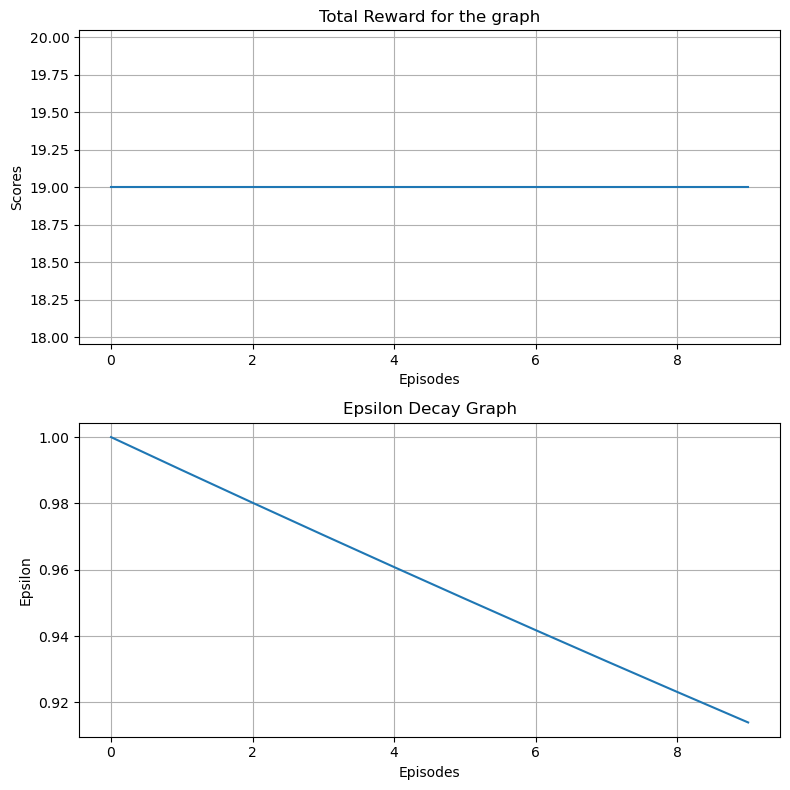

****************************** Evaluation Results : Discount Factor value is 0.65 ******************************


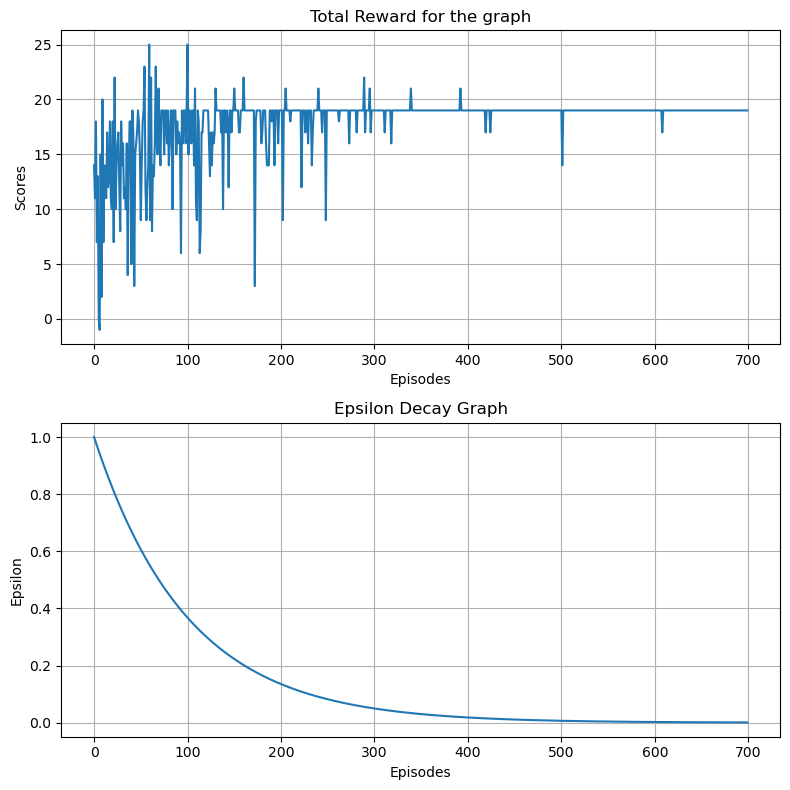

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[-1.24148889e+00  1.89912592e+00  2.31784712e+00  5.95738966e+00]
 [-4.21257285e-01  2.56811347e-01  2.30578952e-01  2.58994704e+00]
 [ 1.22192063e-01 -8.72214908e-01  2.47238850e-01  2.29645074e+00]
 [-7.92617094e-01 -1.35742713e-01  6.04067710e-02  3.44708280e+00]
 [ 8.20595242e-01  1.39444554e-02  1.22966148e-01  4.39735627e+00]
 [ 4.32785589e-03 -1.23417635e-01  1.3

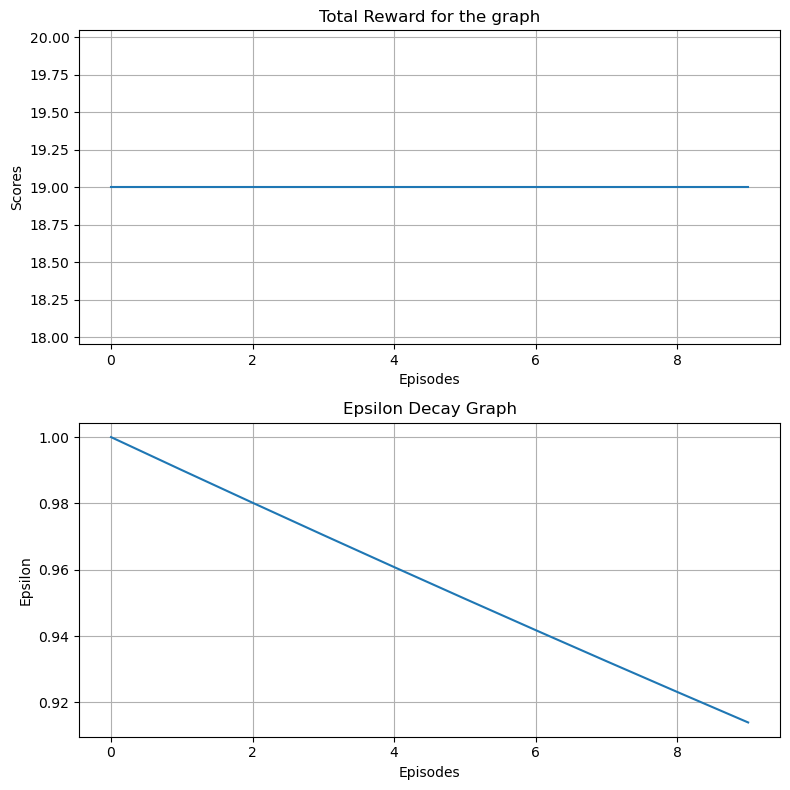

****************************** Evaluation Results : Discount Factor value is 0.8 ******************************


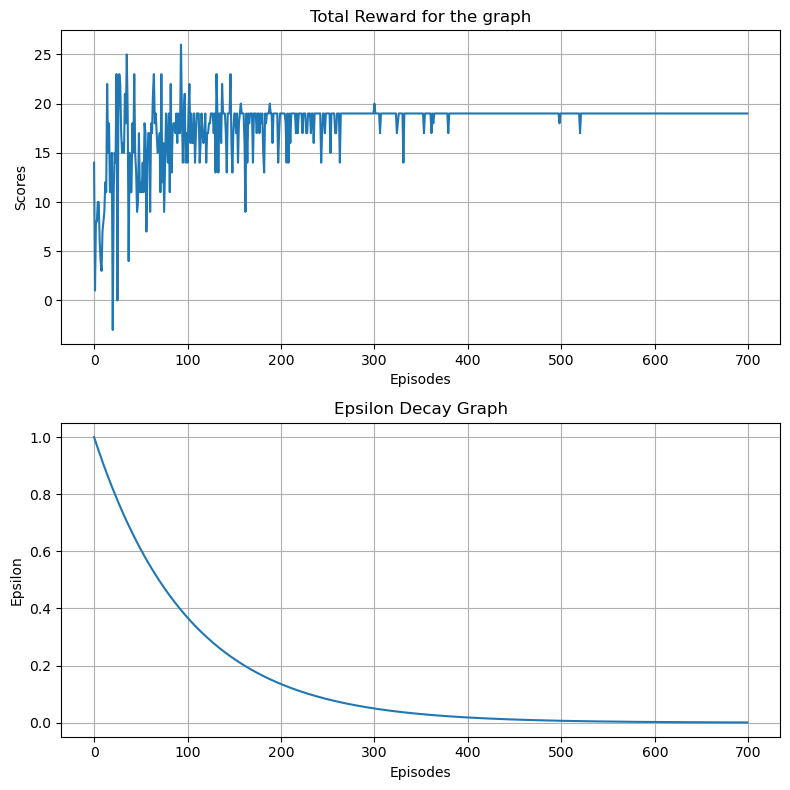

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[ 3.72869896e-03  3.75377557e+00  3.64657349e+00  9.42558478e+00]
 [-4.76975623e-01  5.04427462e-01  3.10827366e-01  5.07101107e+00]
 [ 2.71460413e-01 -1.92232959e-01  3.01523304e-01  4.04403568e+00]
 [-1.00704839e+00  4.75128740e-02  5.88156685e-01  5.86136755e+00]
 [ 5.37355200e-01  2.07301482e-01  3.50844523e-01  5.88787036e+00]
 [-2.09600000e-03 -1.86070498e-01 -2.2

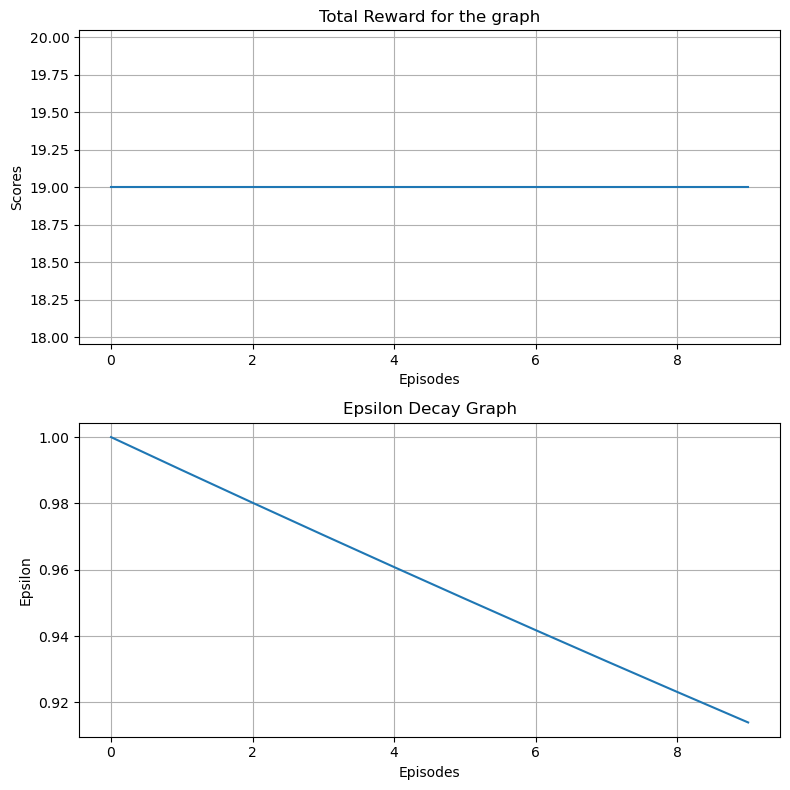

In [255]:
gammaList = [0.40, 0.65, 0.80]
for gamma in gammaList:
    print(f"{'*'*30} Evaluation Results : Discount Factor value is {gamma} {'*'*30}")
    cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
    total_state = cat_quest.space.n
    total_action = cat_quest.action_space.n
    epsilon=0.01
    total_episodes = 700
    learning_rate = 0.1
    Isgreedy = False    
    Q_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
    inital_Q = Q_table.copy()
    epsilon_List, SARSA_scores_df, Q_table= SARSA_algorithm(cat_quest,epsilon, 500, Q_table, Isgreedy, gamma, learning_rate, total_episodes)
    graphs(total_episodes, SARSA_scores_df, epsilon_List)
    print(f"Intial Q table values:\n{inital_Q}\n{'*'*20}Trained Q table values{'*'*20}\n{Q_table}")
    Isgreedy = True
    total_episodes = 10
    epsilon_List, SARSA_scores_greedy_df, Q_table= SARSA_algorithm(cat_quest,epsilon, 500, Q_table, Isgreedy, gamma, learning_rate, total_episodes)
    graphs(total_episodes, SARSA_scores_greedy_df, epsilon_List)


# Decay Rate values => [0.001, 0.009, 0.05] :  : HyperParameter Tuning

****************************** Evaluation Results : Decay Factor is 0.001 ******************************


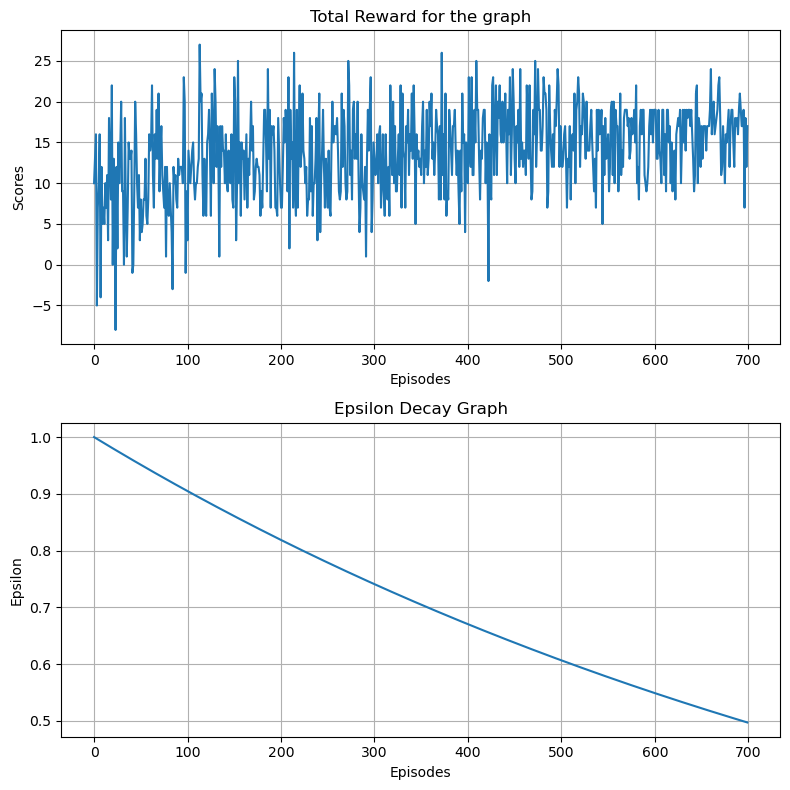

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[ 5.29377176  8.43834323  8.16590842 10.36203311]
 [ 5.19062116  6.92600082  5.49604896  9.31246107]
 [ 6.90510161  3.83198983  5.64267767  8.50571148]
 [ 4.81500118  4.10668247  5.44030148  9.62592911]
 [ 6.69941229  3.4726123   6.10462575  9.76972431]
 [ 2.9256874   5.06593199  2.83110544  7.81100277]
 [ 9.24919012  8.48423811  8.54422563  3.14602028]
 [11.1725867   8

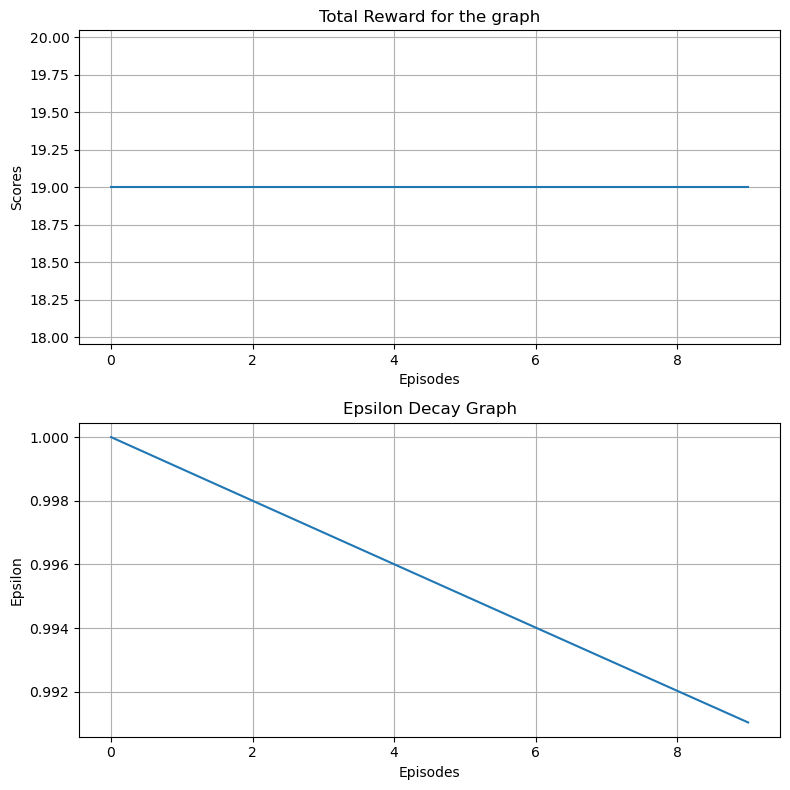

****************************** Evaluation Results : Decay Factor is 0.009 ******************************


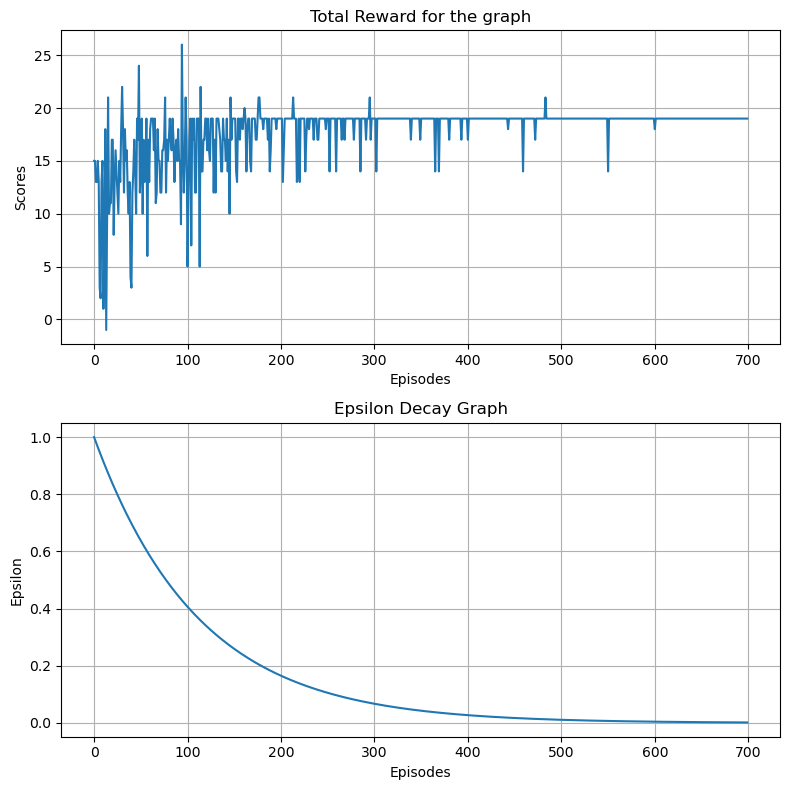

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[ 3.75863533e+00  9.64211964e+00  6.13028193e+00  1.83080178e+01]
 [ 5.76888301e-01  2.41062446e+00  1.09568709e+00  1.10832486e+01]
 [ 7.83369449e-01 -1.21005082e-01  6.28576695e-01  7.88184675e+00]
 [ 4.07896339e-01  6.08898366e-01  2.75163951e-01  9.22820321e+00]
 [ 1.39041713e+00  1.43259185e-01  4.46657474e-01  8.64212631e+00]
 [ 2.79393420e-02  1.21731201e+00  8.7

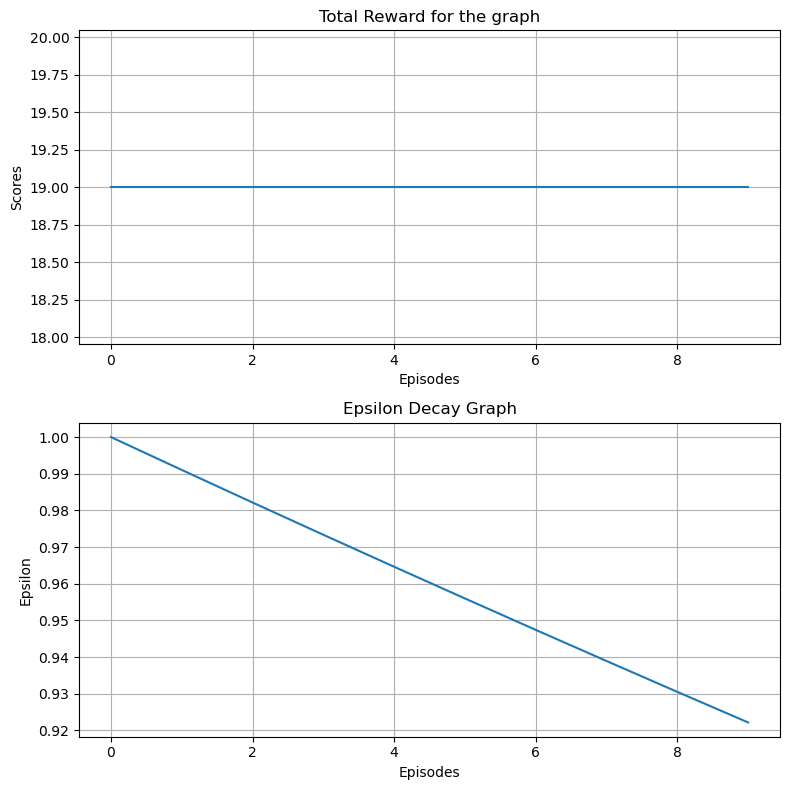

****************************** Evaluation Results : Decay Factor is 0.05 ******************************


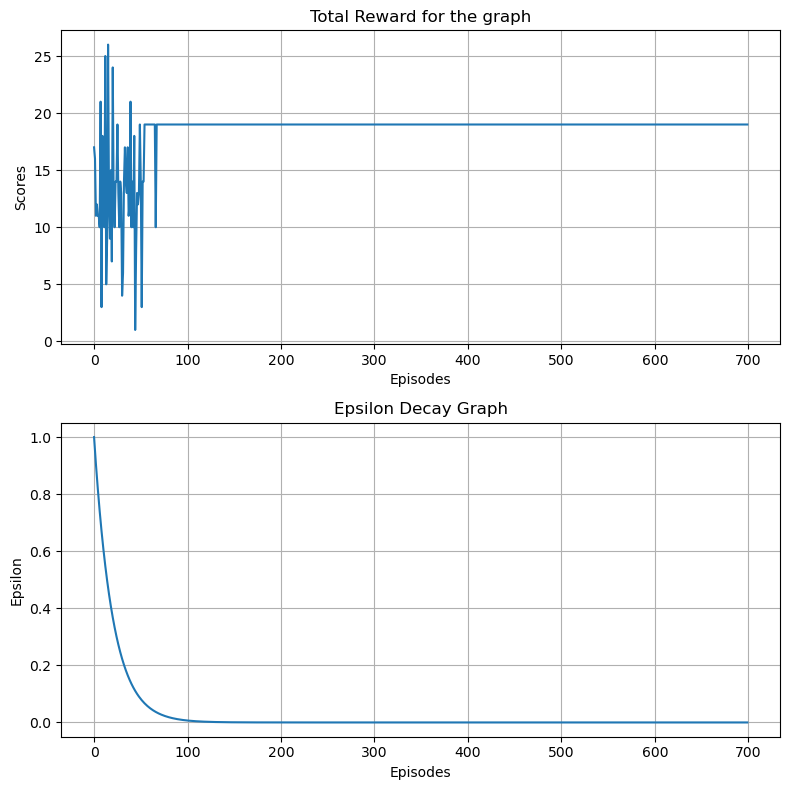

Intial Q table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q table values********************
[[-1.12191215e-01  1.12790456e+00  1.23946259e+00  1.83319885e+01]
 [-2.83326644e-01  1.57145773e+00  9.47335259e-03  2.27977989e-01]
 [-6.74617875e-03 -1.46269985e-01 -2.49198015e-02  4.61386543e-01]
 [-2.00000000e-01 -1.69408589e-01  9.30433708e-03  3.46443157e-01]
 [ 5.70000000e-01  6.20340416e-05  0.00000000e+00  0.00000000e+00]
 [-9.90000000e-03  0.00000000e+00  0.0

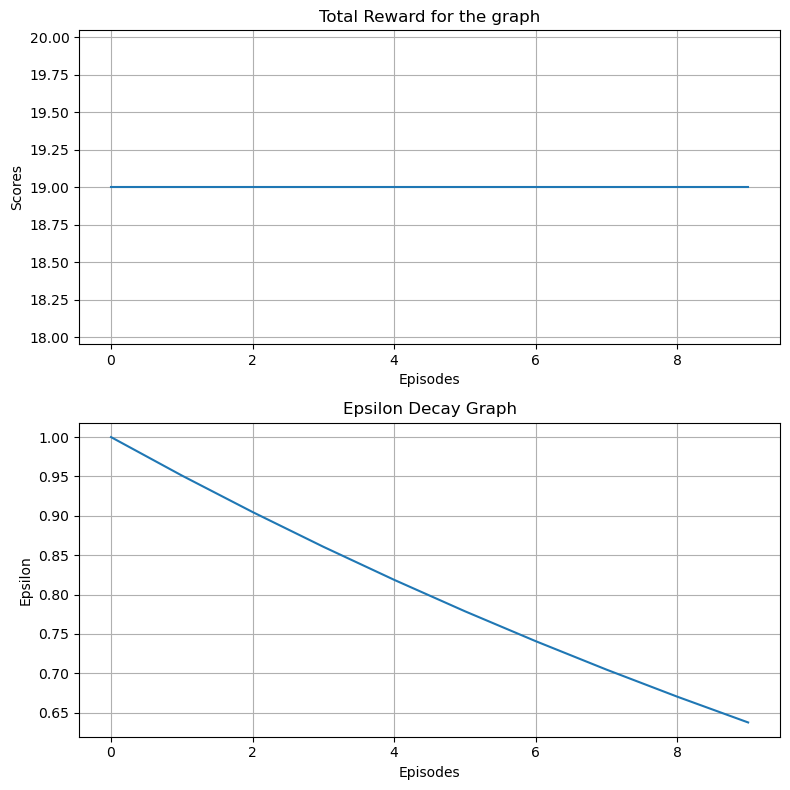

In [256]:
epsilonTuningList = [0.001, 0.009, 0.05]
for epsilon in epsilonTuningList:
    print(f"{'*'*30} Evaluation Results : Decay Factor is {epsilon} {'*'*30}")
    cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
    total_state = cat_quest.space.n
    total_action = cat_quest.action_space.n
    gamma = 0.99
    total_episodes = 700
    learning_rate = 0.1
    Isgreedy = False    
    Q_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
    inital_Q = Q_table.copy()
    epsilon_List, SARSA_scores_E, Q_table= SARSA_algorithm(cat_quest,epsilon, 500, Q_table, Isgreedy, gamma, learning_rate, total_episodes)
    graphs(total_episodes, SARSA_scores_E, epsilon_List)    
    print(f"Intial Q table values:\n{inital_Q}\n{'*'*20}Trained Q table values{'*'*20}\n{Q_table}")
    Isgreedy = True
    total_episodes = 10
    epsilon_List, SARSA_scores_greedy_E, Q_table= SARSA_algorithm(cat_quest,epsilon, 500, Q_table, Isgreedy, gamma, learning_rate, total_episodes)

    graphs(total_episodes, SARSA_scores_greedy_E, epsilon_List)


# Part 3 Double Q learning Implementation

In [257]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
total_state = cat_quest.space.n
total_action = cat_quest.action_space.n
epsilon=0.01
total_episodes = 1000
learning_rate = 0.1
gamma = 0.70
Isgreedy = False
print(f"Total Number of states {total_state} and total number of actions are {total_action}")
print(f"Learning rate (alpha): {learning_rate}\nDiscount_factor: {gamma}\nTotal Episodes: {total_episodes}")
print("*"*120)


Total Number of states 36 and total number of actions are 4
Learning rate (alpha): 0.1
Discount_factor: 0.7
Total Episodes: 1000
************************************************************************************************************************


# Double Q Learning Implementation using  ∑-greedy policy

In [258]:
def DoubleQ_learning_algorithm(cat_quest,df, max_steps, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes):
    epsilon_list = []
    cummulative_score = []
    final_epsilon =0
    initial_epsilon =1
 
    
    for episode in range(total_episodes):
        cat_quest.reset()
        state = 0
        goal_reached = False   
        steps = 0
        score = 0
        epsilon = final_epsilon + (initial_epsilon - final_epsilon) * np.exp(-df * episode)        
        if Isgreedy or np.any(np.random.uniform(0, 1) > epsilon):
            action =  np.argmax(Q1_table[state] + Q2_table[state])
        else:
            action = cat_quest.action_space.sample()
        while not goal_reached and steps <= max_steps:
            steps += 1
            state_, goal_reached, reward, finished, truncated = cat_quest.step(action)
            score += reward
            if Isgreedy or np.any(np.random.uniform(0, 1) > epsilon):
                action_ =  np.argmax(Q1_table[state_] + Q2_table[state_])
            else:
                action_ = cat_quest.action_space.sample()
            if np.random.random() < 0.5:   
                Q1_table[state,action] = Q1_table[state,action] + learning_rate * (reward + gamma * Q2_table[state_,np.argmax(Q1_table[state_])] - Q1_table[state,action])
            
            else:
                Q2_table[state,action] = Q2_table[state,action] + learning_rate * (reward + gamma * Q1_table[state_, np.argmax(Q2_table[state_])] - Q2_table[state,action])
            action = action_
            state = state_        
        epsilon_list.append(epsilon)
        cummulative_score.append(score)
    return epsilon_list, cummulative_score, Q1_table, Q2_table          
            

In [259]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
Q1_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
Q2_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
inital_Q1 = Q1_table.copy()
inital_Q2 = Q2_table.copy()
epsilon_List, DQL_scores, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 100, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes)


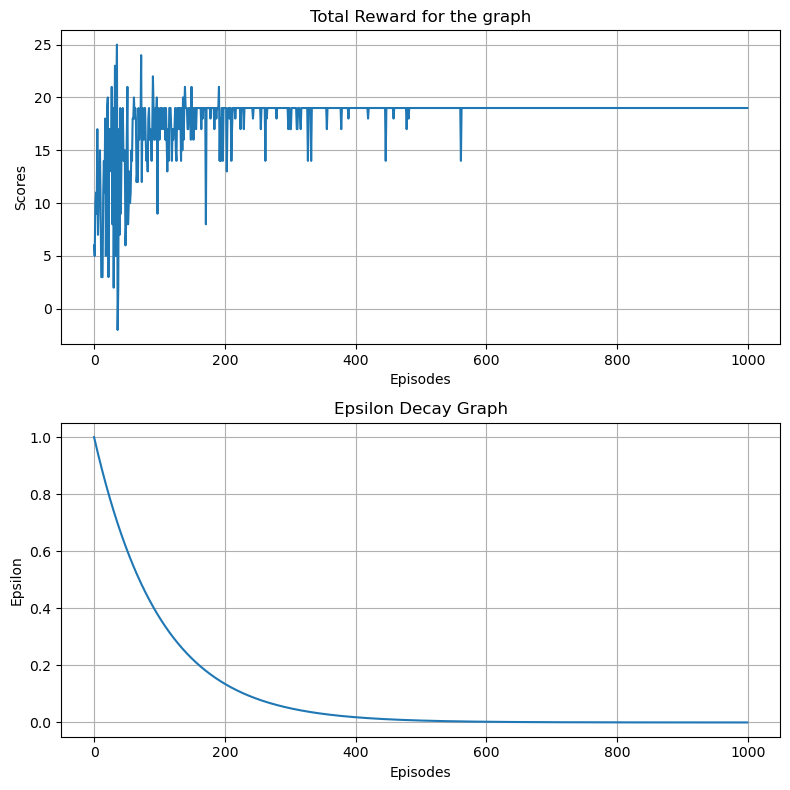

In [260]:
graphs(total_episodes, DQL_scores, epsilon_List)

In [201]:
print(f"Intial Q1 table values:\n{inital_Q1}\n{'*'*20}Trained Q1 table values{'*'*20}\n{Q1_table}")

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[-2.73340274e-01  2.81753344e+00  2.06273941e+00  6.87100000e+00]
 [-5.38015102e-02  3.48758157e+00  5.25094818e-01  1.28839088e+00]
 [ 9.73946647e-02  1.94579437e-01  3.06222855e-01  3.06310172e+00]
 [-2.20324268e-01  1.56416376e-01  2.79335442e-01  2.60604534e+00]
 [ 1.01812296e+00  1.31128929e-02  4.93536343e-02  4.64914580e+00]
 [-7.14581000e-03  4.08196764e-01 -4

In [202]:
print(f"Intial Q2 table values:\n{inital_Q2}\n{'*'*20}Trained Q2 table values{'*'*20}\n{Q2_table}")

Intial Q2 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q2 table values********************
[[-2.35647118e-01  2.16981844e+00  1.96964924e+00  6.87100000e+00]
 [-2.57101209e-01  3.07601339e+00  5.56987640e-01  1.23571181e+00]
 [ 2.23381197e-01  1.11114393e-01  3.39252150e-01  2.84391782e+00]
 [-5.10263496e-01 -4.00407140e-02  1.80318558e-01  4.51983720e+00]
 [ 4.66346362e-01  9.31943302e-02  1.73915781e-01  5.36790853e+00]
 [ 0.00000000e+00 -2.76023843e-02  1

## Agent choosing only greedy actions from the learned policy Double Q Learning

In [261]:
Isgreedy = True
gamma = 0.90
total_episodes = 10
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
epsilon_List, DQL_scores_greedy, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 150, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, 10)


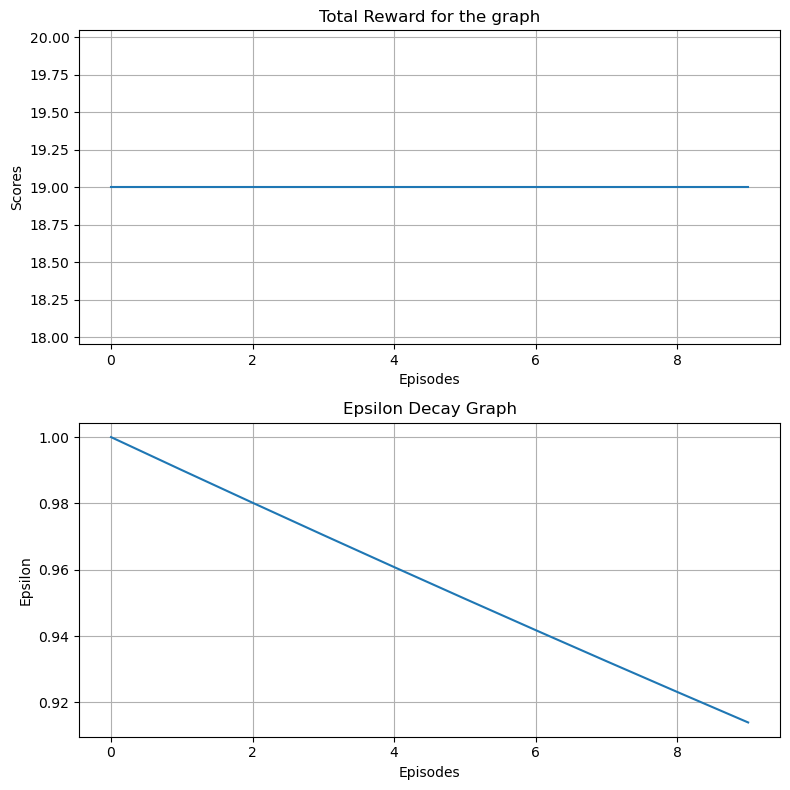

In [262]:
graphs(total_episodes, DQL_scores_greedy, epsilon_List)

## Discount Factor -> [0.40, 0.65, 0.80] : HyperParameter Tuning

****************************** Evaluation Results : Discount Factor value is 0.4 ******************************


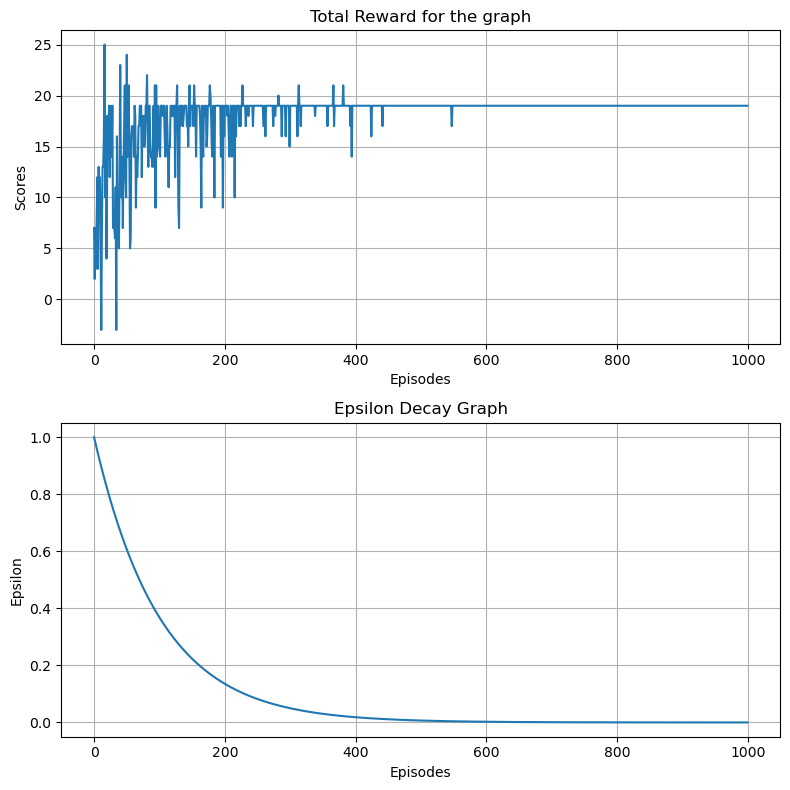

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[-1.01343496e+00  8.03108387e-01  9.36300822e-01  3.65920000e+00]
 [-6.00923284e-01  8.00564351e-01  1.17915802e-01  2.83253956e-01]
 [ 7.00332861e-02  3.87586496e-03  9.69766502e-02  1.17983969e+00]
 [-7.78851170e-01 -2.72763914e-01  2.32637925e-02  1.36731121e+00]
 [ 9.43977000e-01  6.97113263e-03  1.69959833e-01  2.86289768e+00]
 [ 0.00000000e+00 -4.17054913e-01  0

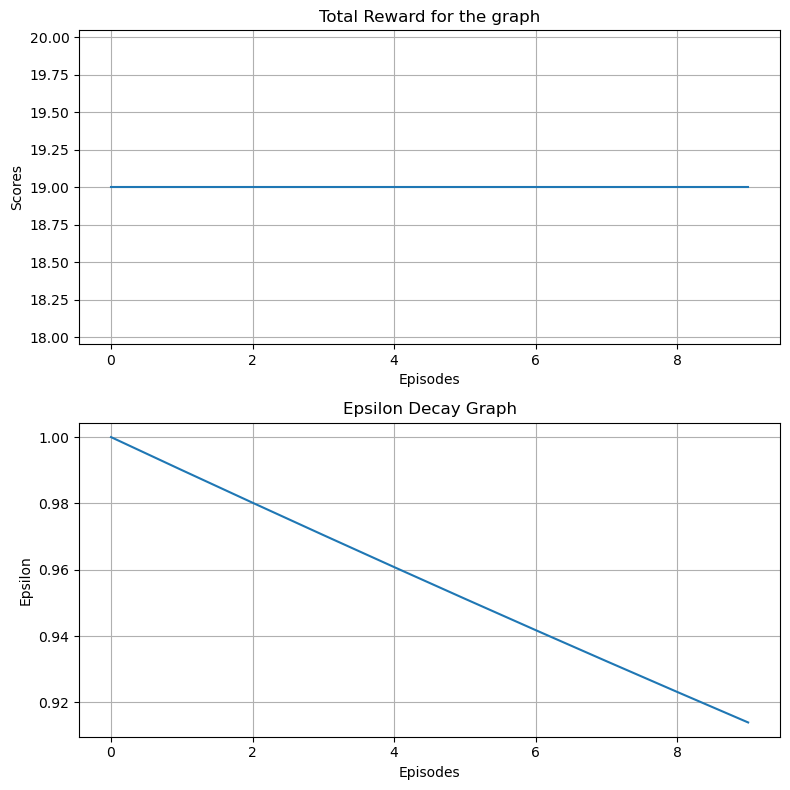

****************************** Evaluation Results : Discount Factor value is 0.65 ******************************


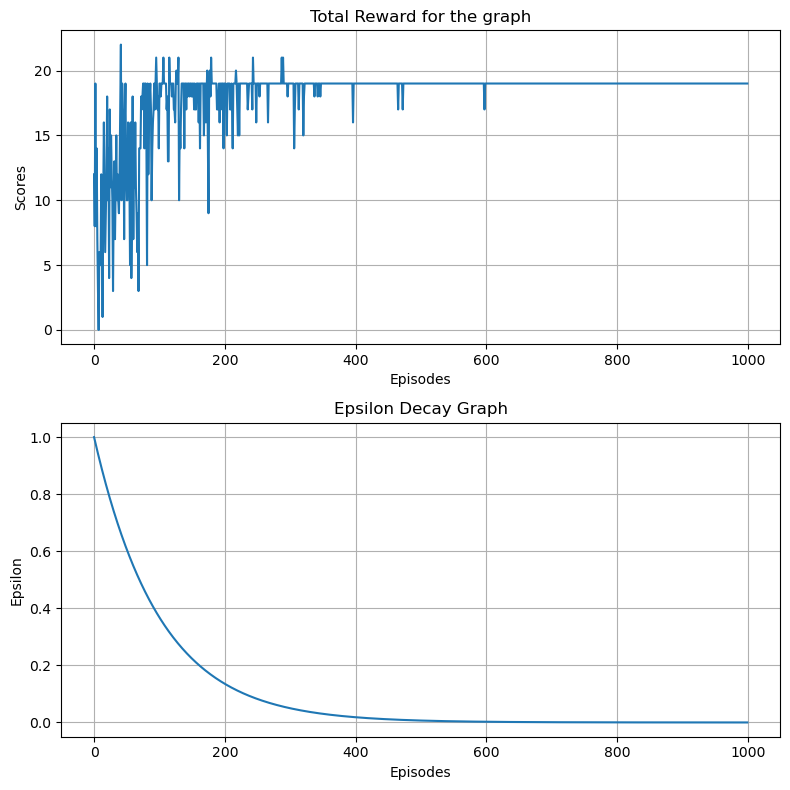

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[-7.39761885e-01  2.33613358e+00  1.86751040e+00  5.96330937e+00]
 [-2.99698284e-01  2.14971726e+00  3.46187936e-01  1.25160045e+00]
 [ 1.08858144e-01 -4.37015272e-02  3.24375910e-01  2.56454453e+00]
 [-6.72877405e-01  3.35412707e-01  5.83854954e-02  1.59117400e-01]
 [ 0.00000000e+00  1.99810000e-02  3.62895000e-02  3.81563740e+00]
 [ 0.00000000e+00  7.27889510e-02  0

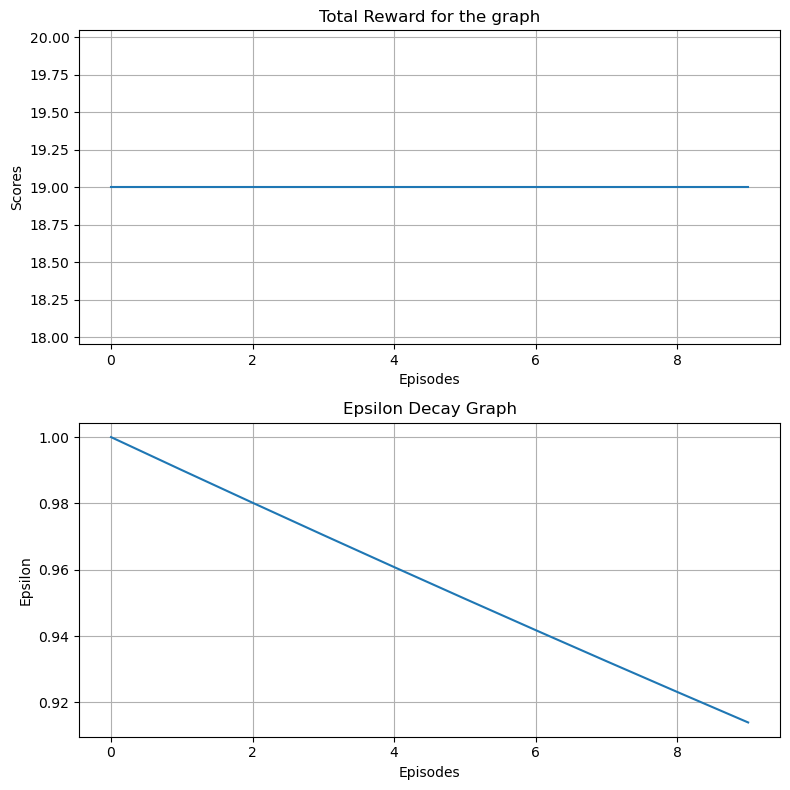

****************************** Evaluation Results : Discount Factor value is 0.8 ******************************


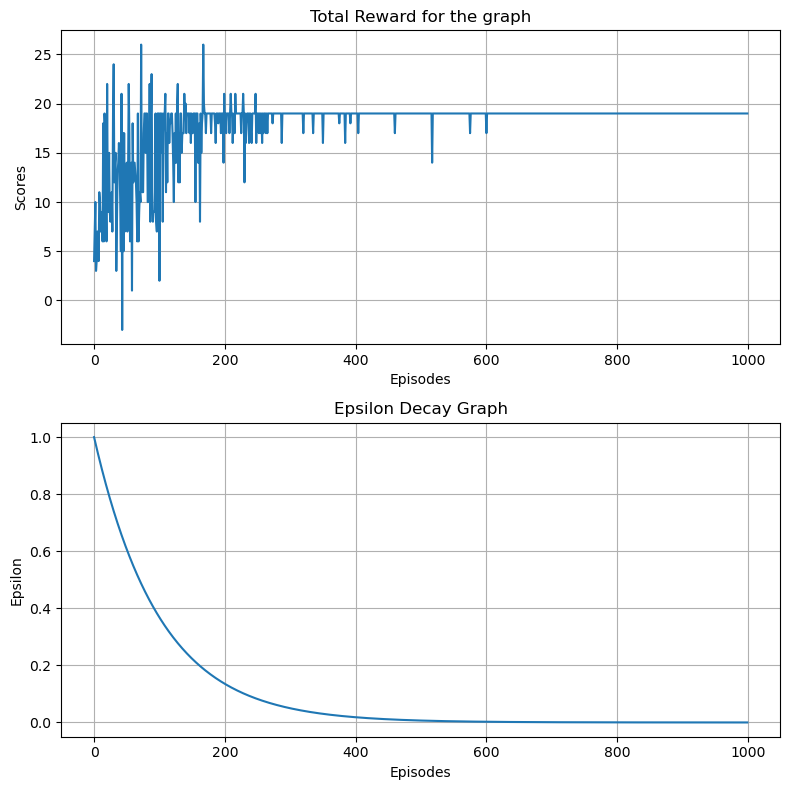

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[-9.82116205e-02  4.85133387e+00  2.63217486e+00  9.42560000e+00]
 [ 1.11056567e-01  3.71176977e+00  7.71294875e-01  1.79817491e+00]
 [ 2.03296211e-01  1.87927966e-01  5.45459014e-01  3.93211989e+00]
 [ 0.00000000e+00  3.65216188e-02  9.97487534e-02  3.71062570e+00]
 [ 4.03201115e-01  3.35247597e-01  1.60407585e-01  3.99935341e+00]
 [-1.65449597e-02  6.04653723e-01 -2

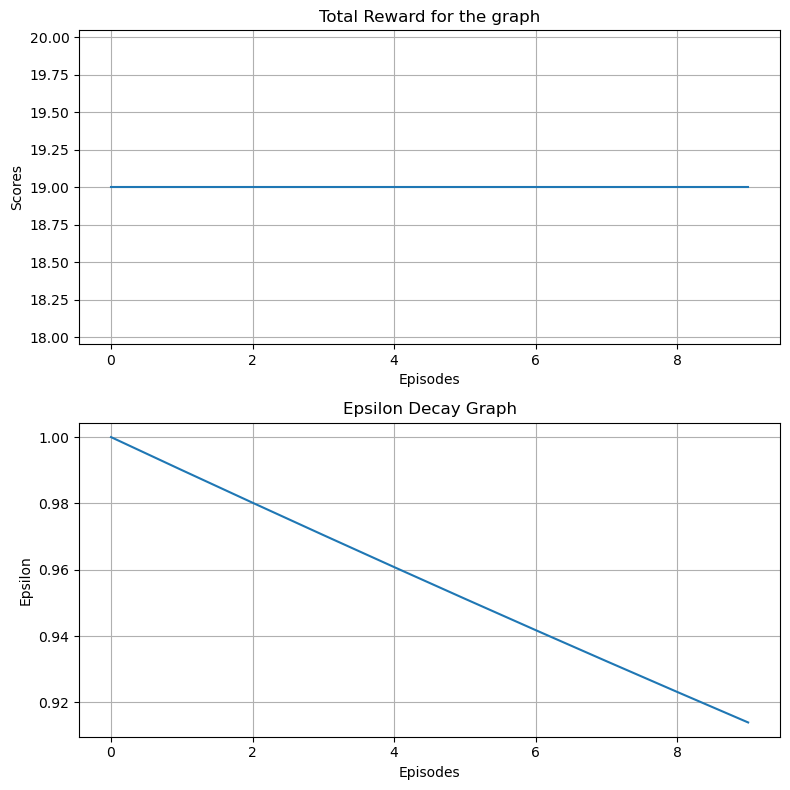

In [263]:
gammaList = [0.40, 0.65, 0.80]
for gamma in gammaList:
    print(f"{'*'*30} Evaluation Results : Discount Factor value is {gamma} {'*'*30}")
    cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
    total_state = cat_quest.space.n
    total_action = cat_quest.action_space.n
    epsilon=0.01
    total_episodes = 1000
    learning_rate = 0.1
    Isgreedy = False
    Q1_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
    Q2_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))    
    epsilon_List, DQL_scores_df, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 200, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes)
    graphs(total_episodes, DQL_scores_df, epsilon_List)
    print(f"Intial Q1 table values:\n{inital_Q1}\n{'*'*20}Trained Q1 table values{'*'*20}\n{Q1_table}")
    print(f"Intial Q2 table values:\n{inital_Q2}\n{'*'*20}Trained Q2 table values{'*'*20}\n{Q2_table}")
    Isgreedy = True
    total_episodes = 10
    epsilon_List, DQL_scores_greedy_df, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 200, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes)

    graphs(total_episodes, DQL_scores_greedy_df, epsilon_List)


## Decay Rate values => [0.001, 0.009, 0.05] : : HyperParameter Tuning

****************************** Evaluation Results : Decay Factor is 0.001 ******************************


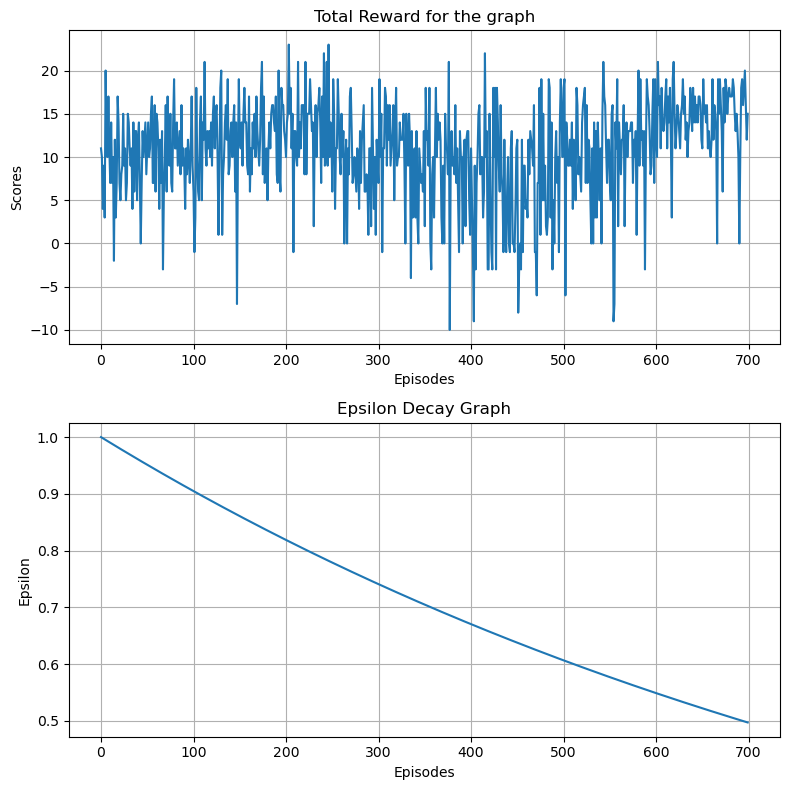

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[16.77408272 19.95819401 21.53793769 23.21459696]
 [17.87549937 19.5734226  16.73048416 20.75178704]
 [17.04023433 16.80378599 18.13553659 20.15041983]
 [14.96710983 16.93170149 17.36216982 20.77589336]
 [13.32491848 16.39606757 15.80993435 20.34178768]
 [ 6.89966097 16.57668673  6.35021689  4.95669078]
 [20.94242436 19.21592687 20.37935841 16.36738866]
 [20.88143859 

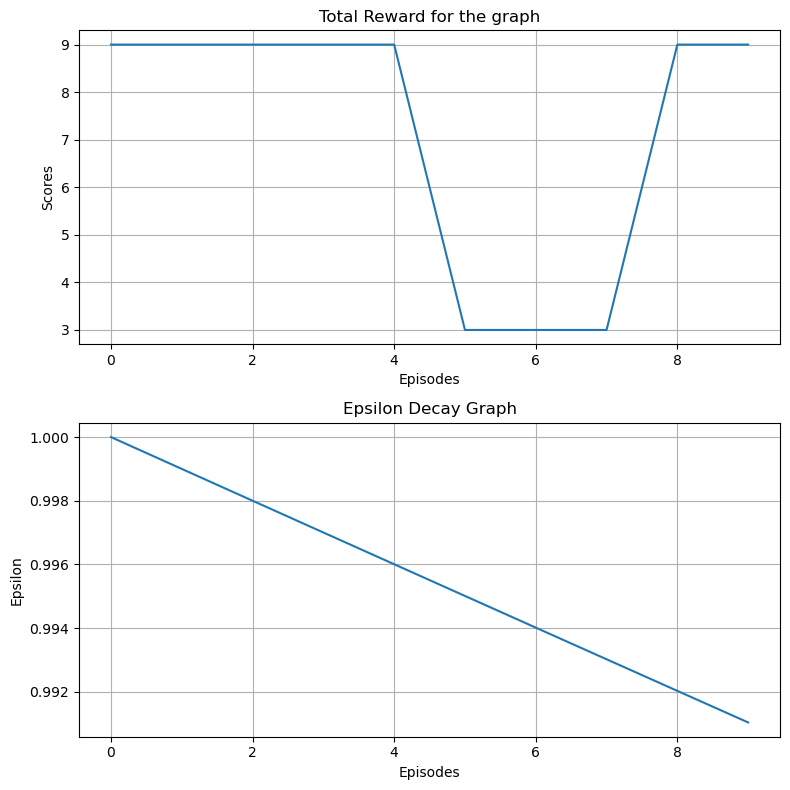

****************************** Evaluation Results : Decay Factor is 0.009 ******************************


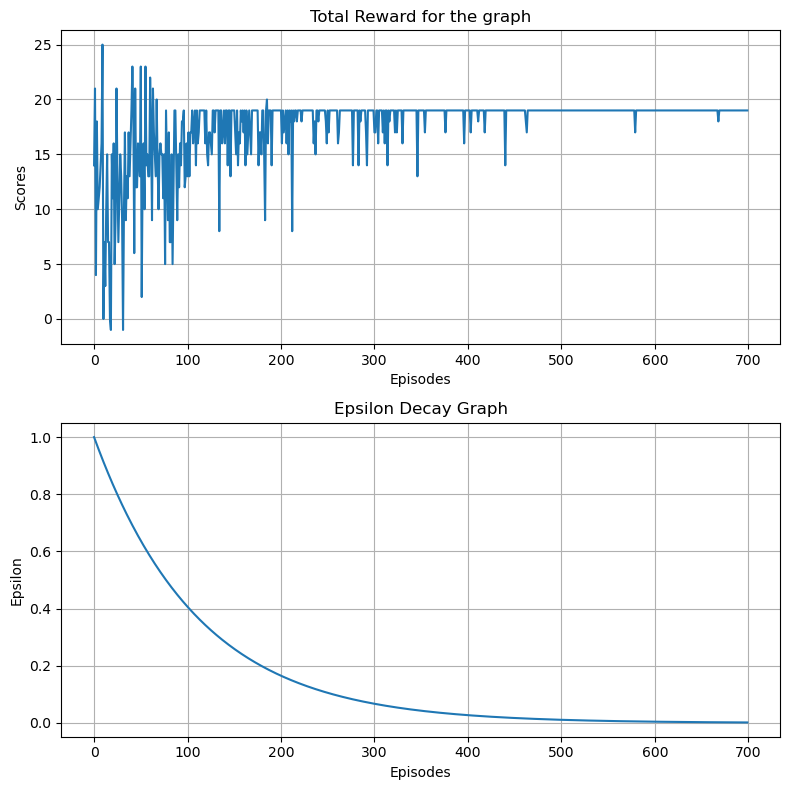

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[ 5.27928691e+00  8.65625274e+00  9.92419158e+00  1.83300460e+01]
 [ 2.26747278e+00  1.13769381e+01  2.20971738e+00  3.25426168e+00]
 [ 4.74230558e-01  9.97983416e-01  1.91094779e+00  9.90973397e+00]
 [-2.41976627e-01  8.40710101e-01  3.02106039e-01  8.13827989e+00]
 [ 1.01615575e+00 -5.78390172e-04  1.96542491e+00  8.53509144e+00]
 [ 4.53093349e-02  1.18518505e+00  4

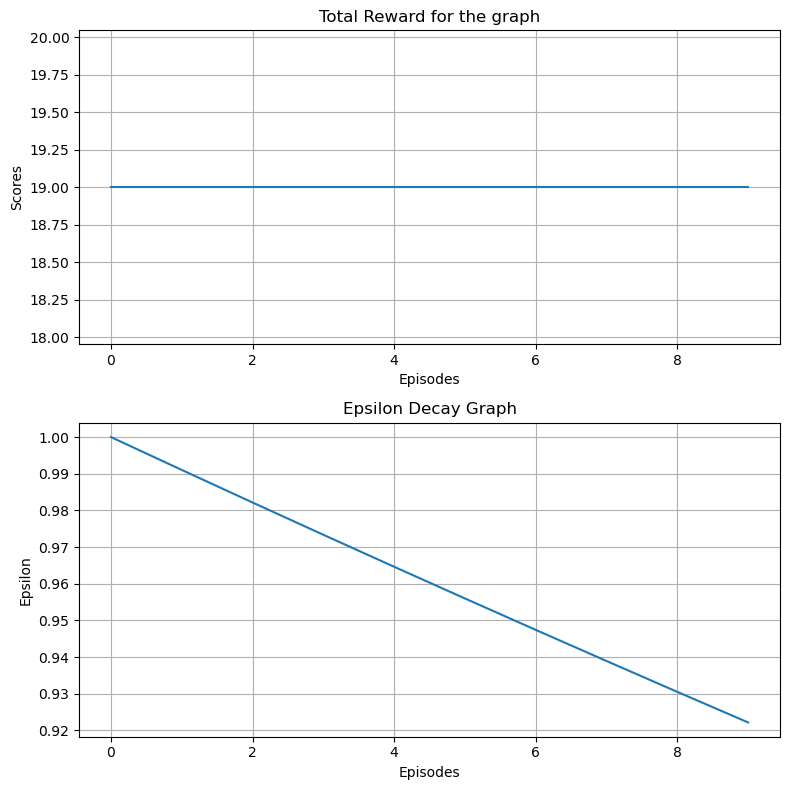

****************************** Evaluation Results : Decay Factor is 0.05 ******************************


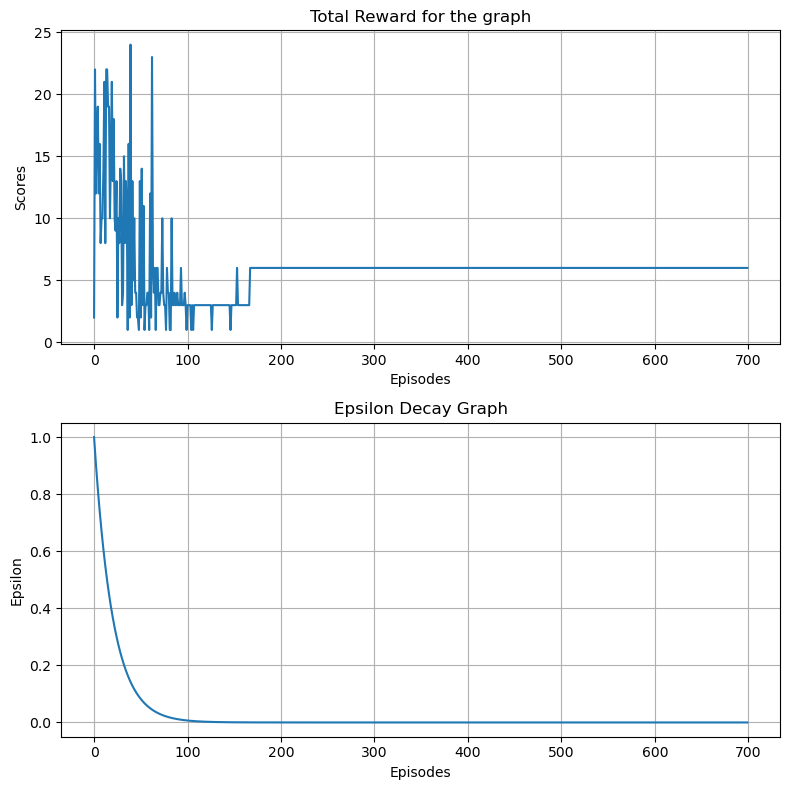

Intial Q1 table values:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
********************Trained Q1 table values********************
[[ 6.72012270e-01  1.68663704e+00  1.67256248e+00  6.18230992e+00]
 [-1.57422054e-01  2.48366985e+00  0.00000000e+00  9.91683000e-02]
 [ 0.00000000e+00 -1.46145108e-01 -5.48856000e-03  5.73161294e-01]
 [-3.80000000e-01 -1.00000000e-01  0.00000000e+00  3.65310000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.97000000e-02  0

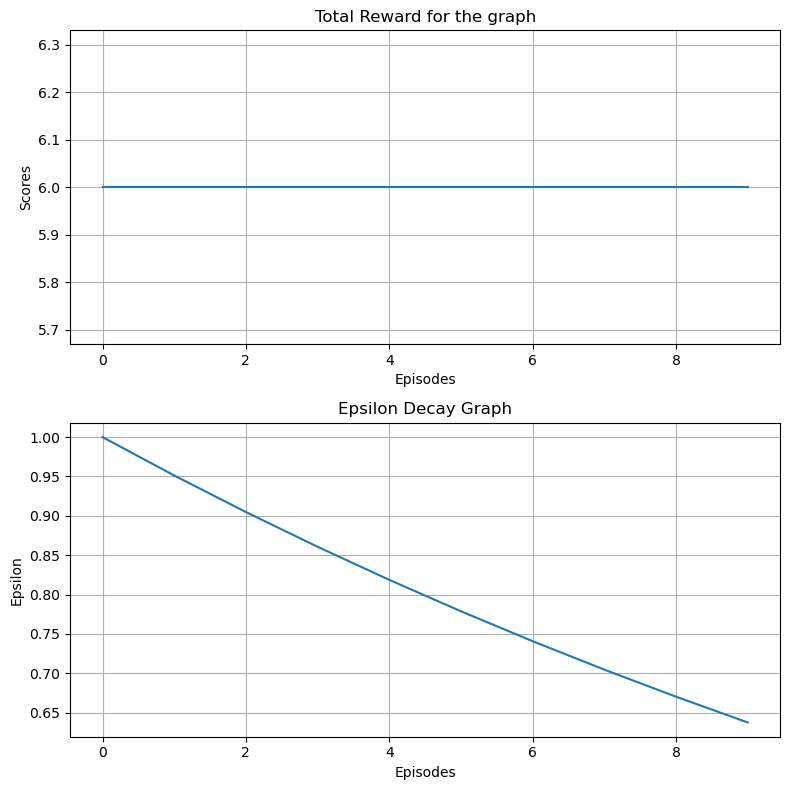

In [264]:
epsilonTuningList = [0.001, 0.009, 0.05]
for epsilon in epsilonTuningList:
    print(f"{'*'*30} Evaluation Results : Decay Factor is {epsilon} {'*'*30}")
    cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
    total_state = cat_quest.space.n
    total_action = cat_quest.action_space.n
    gamma = 0.99
    total_episodes = 700
    learning_rate = 0.1
    Isgreedy = False
    
    Q1_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
    Q2_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))    
    epsilon_List, DQL_scores_E, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 200, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes)
    graphs(total_episodes, DQL_scores_E, epsilon_List)
    print(f"Intial Q1 table values:\n{inital_Q1}\n{'*'*20}Trained Q1 table values{'*'*20}\n{Q1_table}")
    print(f"Intial Q2 table values:\n{inital_Q2}\n{'*'*20}Trained Q2 table values{'*'*20}\n{Q2_table}")
   
    Isgreedy = True
    total_episodes = 10
    epsilon_List, DQL_scores_greedy_E, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 200, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes)

    graphs(total_episodes, DQL_scores_greedy_E, epsilon_List)


# Dynamic Reward Graph

In [272]:
def dynamicsRewardsGraph(DQL_scores, SARSA_scores):
    plt.figure(figsize = (10, 4))
    plt.plot(DQL_scores, color = 'blue', alpha = 0.9, label = 'Double Q Learning rewards')
    plt.plot(SARSA_scores,  color = 'lightcoral', alpha = 0.8, label = 'SARSA rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('SARSA Reward VS Double Q Learning Rewards')
    plt.grid()
    plt.legend()
    plt.show()

In [273]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
total_state = cat_quest.space.n
total_action = cat_quest.action_space.n
epsilon=0.01
total_episodes = 1000
learning_rate = 0.1
gamma = 0.90
Isgreedy = False
Q1_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
Q2_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
Q_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
epsilon_List, SARSA_scores, Q_table= SARSA_algorithm(cat_quest,epsilon, 100, Q_table, Isgreedy, gamma, learning_rate, total_episodes)
epsilon_List, DQL_scores, Q1_table, Q2_table= DoubleQ_learning_algorithm(cat_quest,epsilon, 100, Q1_table, Q2_table, Isgreedy, gamma, learning_rate, total_episodes)


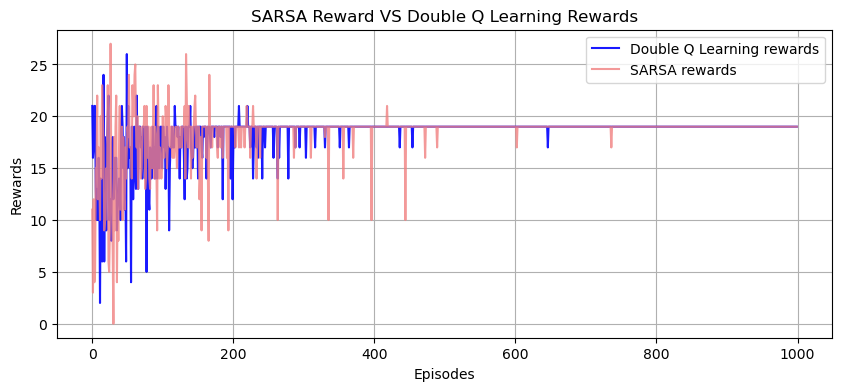

In [274]:
dynamicsRewardsGraph(DQL_scores, SARSA_scores)

# Bonus Task

# N Step Boostrapping SARSA

In [218]:
def n_step_SARSA(cat_quest, n, max_steps, Q_table, epsilon, gamma, learning_rate, total_episodes):
    epsilon_list = []
    cumulative_score = []
    final_epsilon = 0    
    
    for episode in range(total_episodes):
        cat_quest.reset()
        state = 0
        goal_reached = False
        steps = 0
        score = 0
        episode_memory = []        
        while not goal_reached and steps <= max_steps:
            steps += 1 
            if np.random.uniform(0, 1) > epsilon:
                action = np.argmax(Q_table[state])
            else:
                action = cat_quest.action_space.sample()            
            state_, goal, reward, finished, truncated = cat_quest.step(action)
            
            score += reward            
            episode_memory.append((state, action, reward))
            G = 0
            for t in range(min(n, len(episode_memory))):
                G += (gamma ** t) * episode_memory[t][2]
            for t, (s, a, _) in enumerate(episode_memory):
                Q_table[s, a] = Q_table[s, a] + learning_rate * (G - Q_table[s, a])
                G = (G - episode_memory[t][2]) / gamma
            episode_memory = []
            state = state_

            
        epsilon_list.append(epsilon)
        cumulative_score.append(score - 3)    
    return epsilon_list, cumulative_score, Q_table

In [225]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
Q_table = np.zeros((cat_quest.space.n, cat_quest.action_space.n))
inital_Q = Q_table.copy()
total_state = cat_quest.space.n
total_action = cat_quest.action_space.n
epsilon=0.01
total_episodes = 1000
learning_rate = 0.1
epsilon_List, SARSA_n_scores, Q_table= n_step_SARSA(cat_quest, n=3,max_steps= 100, Q_table=Q_table, epsilon=epsilon, gamma=0.99, learning_rate=learning_rate, total_episodes=total_episodes)


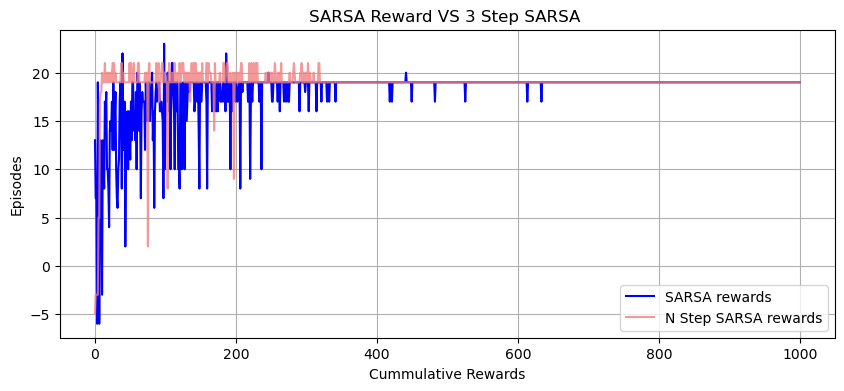

In [246]:
def dynamicsRewardsSGraph(SARSA_scores, SARSA_n_scores):
    plt.figure(figsize = (10, 4))
    plt.plot(SARSA_scores, color = 'blue', label = 'SARSA rewards')
    plt.plot(SARSA_n_scores,  color = 'lightcoral', alpha = 0.8, label = 'N Step SARSA rewards')
    plt.xlabel('Cummulative Rewards')
    plt.ylabel('Episodes')
    plt.title('SARSA Reward VS 3 Step SARSA ')
    plt.grid()
    plt.legend()
    plt.show()

    
dynamicsRewardsSGraph(SARSA_scores,SARSA_n_scores)

# Grid World Scenario Visualization

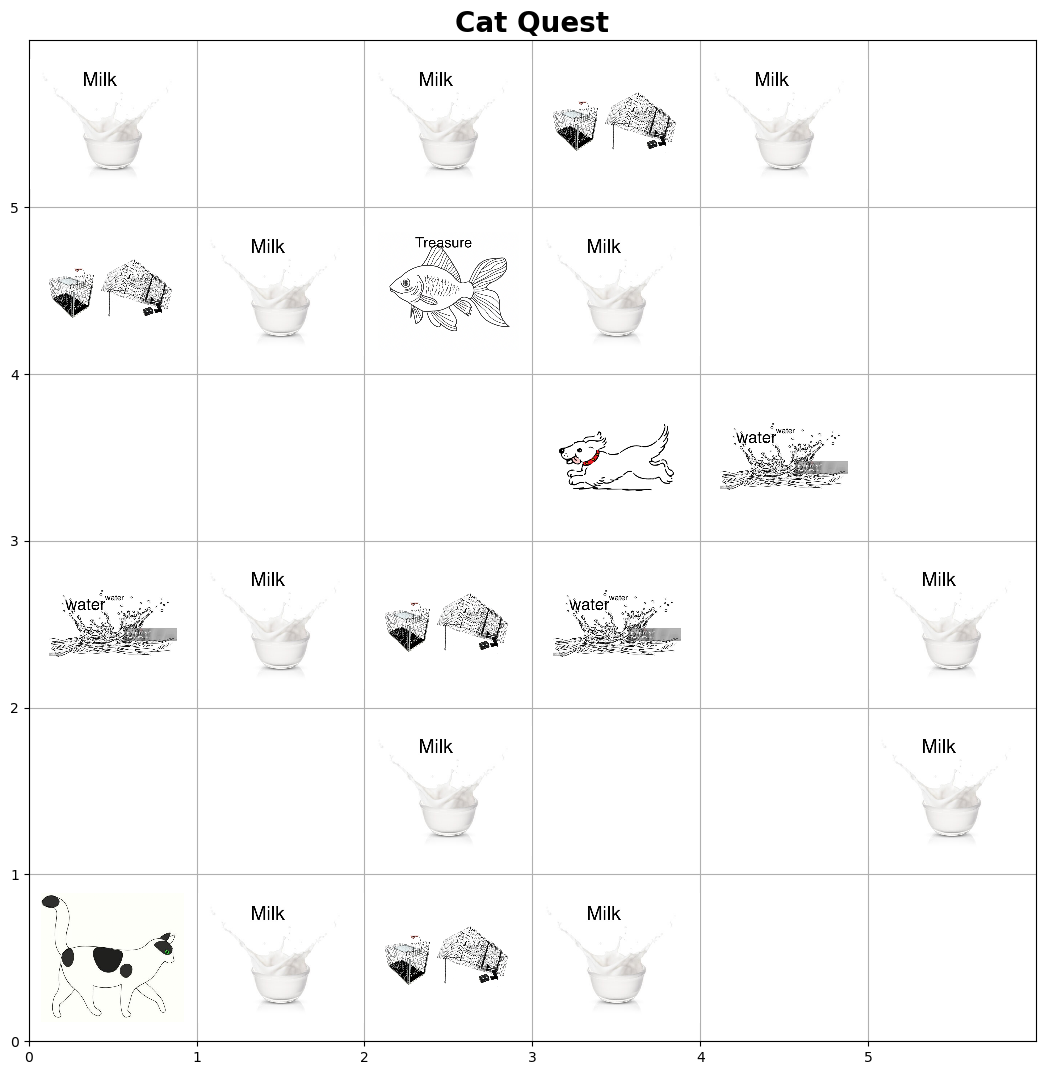

In [121]:
cat_quest = CatQuestEnvironment(env_type = 'deterministic', n = 36,max_steps = 100)
cat_quest.render(plot= True)

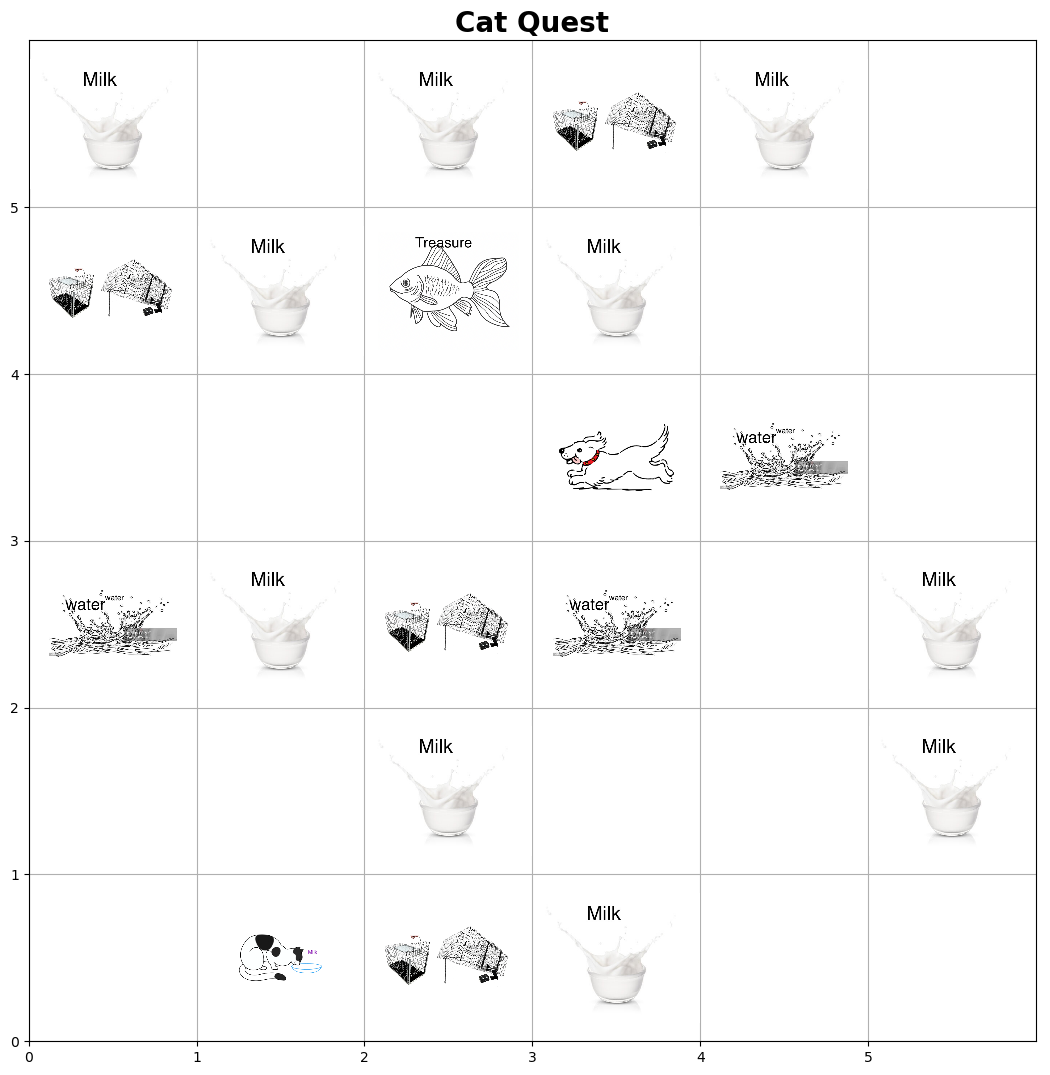

In [122]:
cat_quest.step(3)
cat_quest.render(plot = True)

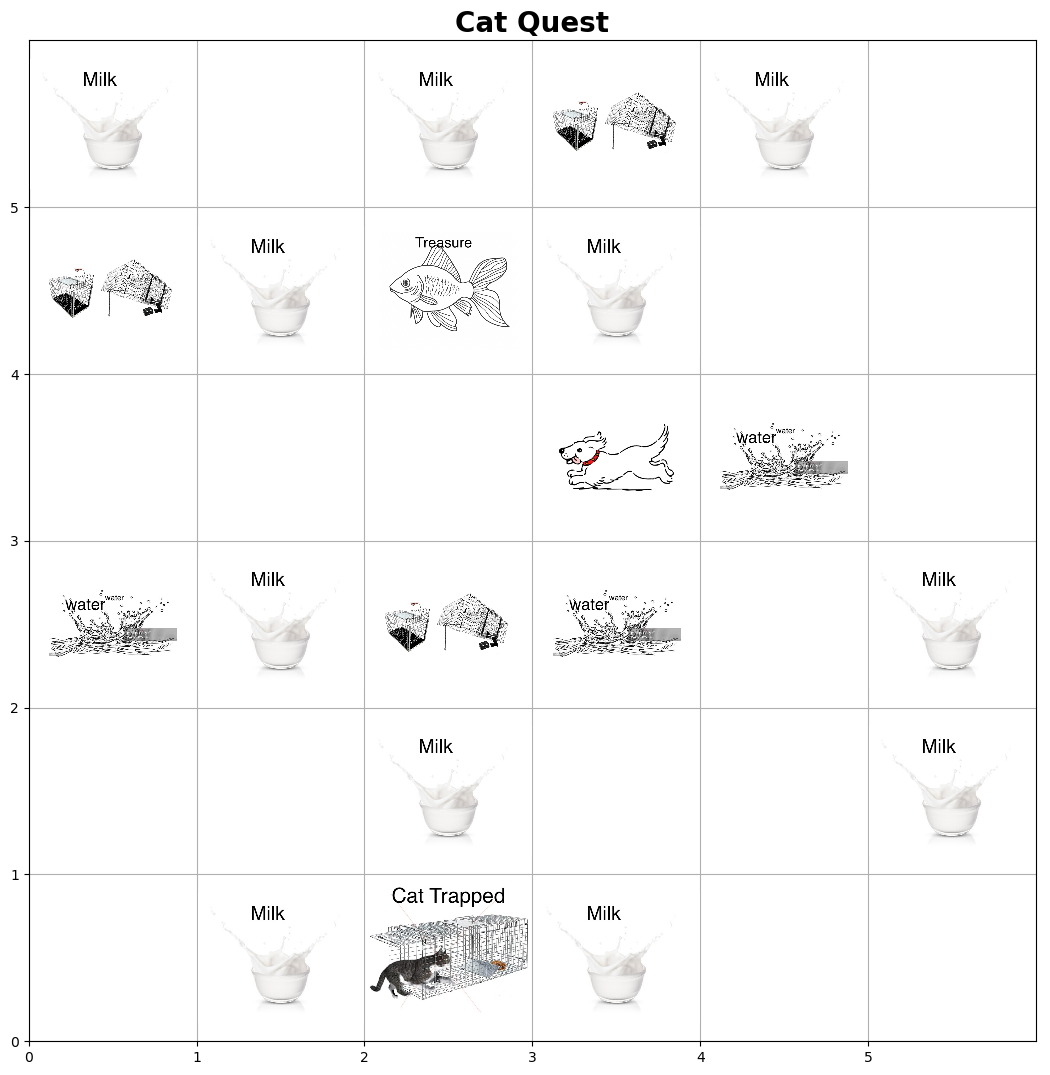

In [123]:
cat_quest.step(3)
cat_quest.render(plot = True)

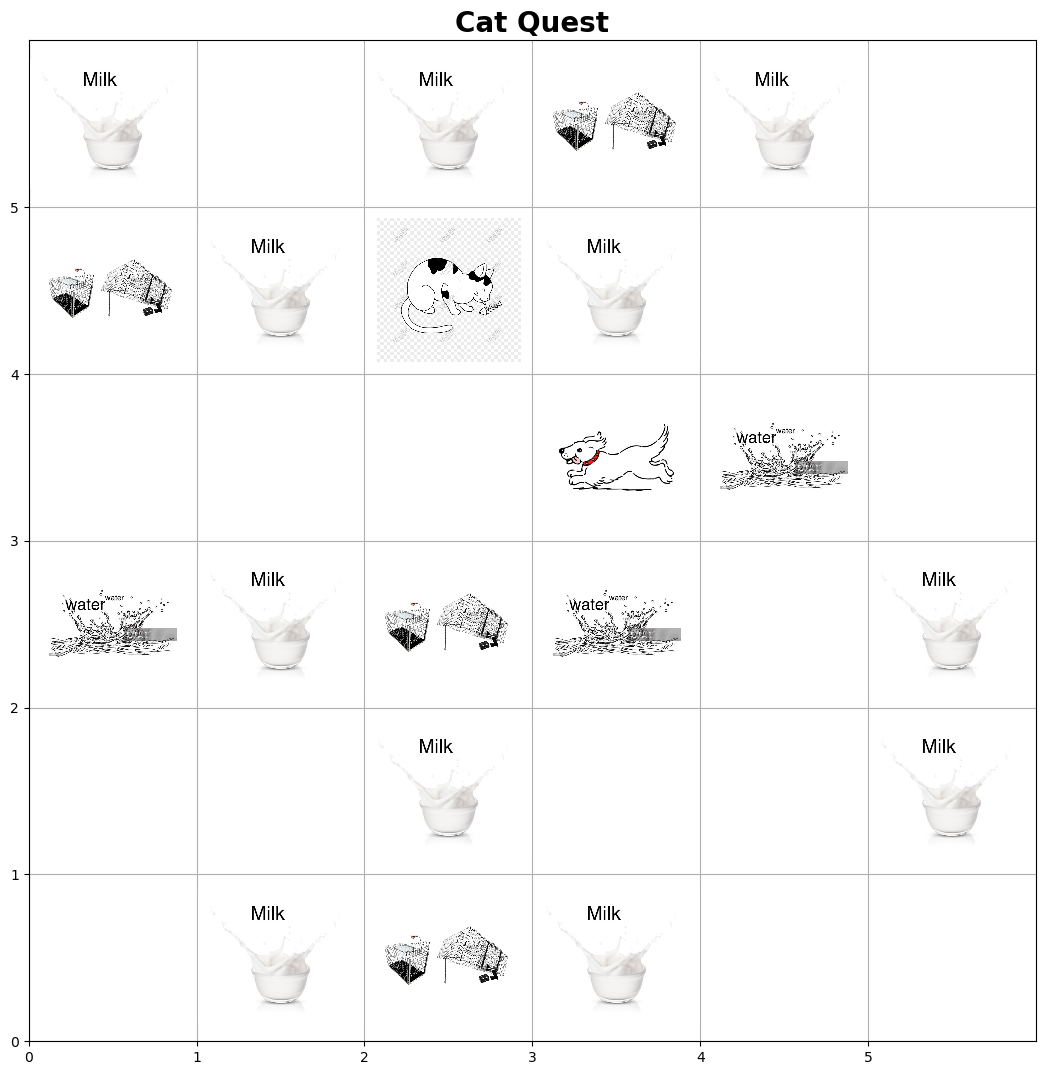

In [124]:
cat_quest.step(0)
cat_quest.step(0)
cat_quest.step(0)
cat_quest.step(0)
cat_quest.render(plot = True)

GAME OVER


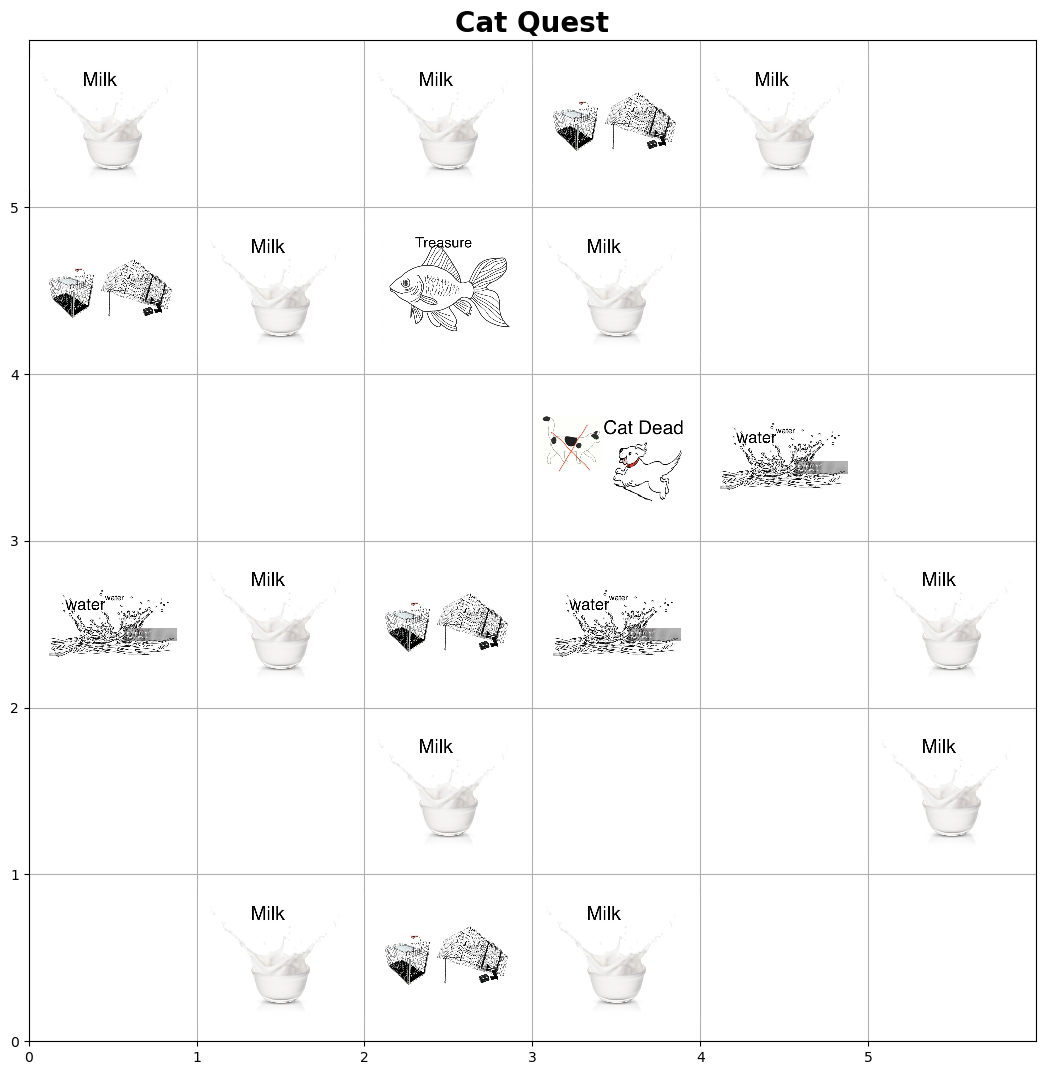

In [125]:
cat_quest.step(3)
cat_quest.step(1)
cat_quest.render(plot = True)

# References


https://ubuffalo-my.sharepoint.com/:f:/g/personal/avereshc_buffalo_edu/Er0ESPRw4HFMjPpRokyJ7TYBPErfobIaPqritqkGpM1EOA?e=vgaaek

https://ubuffalo-my.sharepoint.com/:f:/g/personal/avereshc_buffalo_edu/EukPAiqkHV9FlJBZtB349tsBYhvyPXS71xwA41eVVQjnZg?e=XnJmUy